# Analysis Of Covid-19 Papers With Distributed Systems:

**Group 3 : Asal Rangraziasl, Elaheh Ahmadieslamloo, Melika Keshavarzmirzamohammadi**


**Abstract:**

In this project, we conducted an analysis of COVID-19 papers using distributed systems with a focus on leveraging Dask and distributed computing techniques. Our primary objective was to optimize the allocation of computational resources to achieve the best performance.

During the data analysis, we explored the most frequent words present in these papers. Additionally, we performed intriguing analyses to identify the countries and institutions that made significant contributions to the field. To gauge the overall sentiment of the papers, we conducted a sentiment analysis.

Furthermore, we utilized a pre-trained NLP model to calculate the cosine similarity between paper titles using two different methods. This allowed us to identify similarities between titles and determine which papers were more closely related.

To optimize our analyses, we performed a grid search, systematically varying the number of workers and partitions to find the most effective combination for each task. This process helped us identify the optimal resource allocation, leading to improved performance and efficiency.

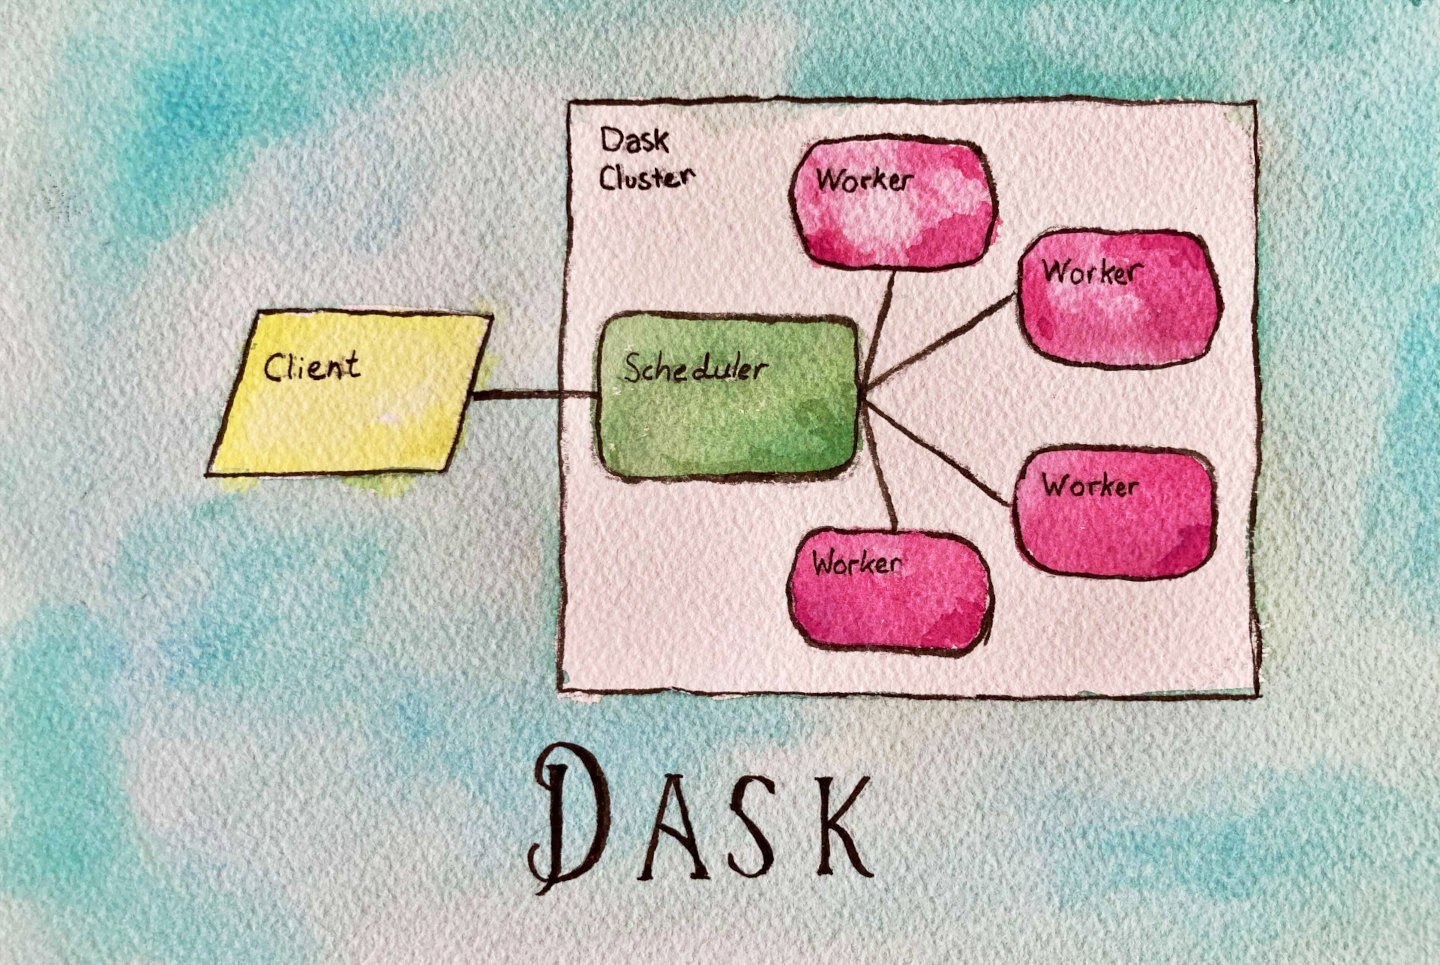

# 0. Virtual Machines:

we have created 2 similar virtual machines with `4 cores` and `8GB of RAM`(Cloudveneto.large) as our workers and a `2 core` machine with `4GB RAM` for the scheduler. We ran jupyter notebook on the scheduler machine; therefore, scheduler was our client as well.


Machines information:


```
SCH_VM : 10.67.22.24

W1_VM  : 10.67.22.209

W2_VM  : 10.67.22.100
```


In order to connect these machines we created a key pair named daskM and daskM.pub with our local machines, and copied them to our machines. Then, we connected the machines with this key pair, since Paramiko which makes the connections under the hood in SSHCluster needed a single private key for the machines.


It is worth mentioning we created a config file to access the scheduler and workers from both our local and virtual machines very easily. It made our job way easier during the project since it would automatically jump from gate.



config file on our local machine: 

```bash

Host gate
	Hostname gate.cloudveneto.it
	User mkeshava
	IdentityFile ~/.ssh/id_rsa
    
    
Host w1
    HostName 10.67.22.209
    User ubuntu
    IdentityFile ~/.ssh/Melika_Key.pem
    ProxyJump gate


Host w2
    HostName 10.67.22.100
    User ubuntu
    IdentityFile ~/.ssh/Melika_Key.pem
    ProxyJump gate


Host sch
    HostName 10.67.22.24
    User ubuntu
    IdentityFile ~/.ssh/Melika_Key.pem
    ProxyJump gate
    
```


we also accessed the schedular jupyter notebook with the help of the config file:


```ssh -N -L localhost::localhost:8888 me```

**with this code we have also created a folder in the scheduler named `data` and we made a shared directory with workers in order to access the papers from workers as well.**

`sshfs sch:/home/ubuntu/data /home/ubuntu/data`

In [1]:
from dask.distributed import Client, SSHCluster
from dask import delayed
import dask.bag as db
import dask.dataframe as ddf
import numpy as np
import csv
import functools
import seaborn as sn
import json
import time
import pandas as pd
import json
import dask 

from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from nltk import word_tokenize
import nltk
import pycountry

from collections import Counter
from operator import itemgetter

import matplotlib.pyplot as plt

from operator import itemgetter
import numpy as np
from dask.utils import format_bytes
import itertools
from numpy.linalg import norm
import os
import io
import json
from flatten_json import flatten
from word2number import w2n
import warnings
from dask.distributed import Client
from dask.distributed import LocalCluster


plt.rcParams['figure.figsize'] = 13, 6

In [ ]:
# !pip install word2number
#!pip install flatten_json
###pip install pycountry

In [2]:
from dask.distributed import Client, LocalCluster

from operator import itemgetter
from operator import add
from operator import iconcat

from nltk.tokenize import RegexpTokenizer

from collections import Counter

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh.palettes as palette
import seaborn as sn
import pandas as pd
import functools

import os
import json
import time

RUN_GRID_SEARCH = True

import graphviz



In [3]:
w1 = "10.67.22.209"
w2 = "10.67.22.100"
sch = "10.67.22.24"

---

---


**Do Not Run The Cell Below:**

bag didn't compute anything, we figured out we had to flatten the json files. we saved the flattened jsons in the one_liner folder in the `data` foler which is shared among scheduler and the workers.

In [ ]:
#the path to the slim datasets:
path = "/home/ubuntu/data/sdata/"
fn = os.listdir(path)


In [ ]:
def flatten(p):
    fn = os.listdir(p)
    for n in fn:
        with open(p+n) as f:
            data = json.load(f)
        json_string = json.dumps(data, separators=(',', ':'))
        
        with open("/home/ubuntu/data/one_liner/"+n, 'w') as f:
            f.write(json_string)
        




flatten(path)

---

---

---
# Local cluster:

First we ran everything (except cosine similarity) on the local cluster which was on the schedular, to see which libraries we need to install everything on the workers, and have the same machines with the same python versions and python packages.

In [ ]:
warnings.filterwarnings("ignore")
cluster = LocalCluster()
c = Client(cluster)

In [ ]:
c

---
# SSH Cluster:

Here we created a cluster with 3 machines dedicating one machine to the scheduler and jupyter notebook, and two machines to workers. in the cluster below we created 4 workers from two machines each having 2 cores.

In [ ]:
warnings.filterwarnings("ignore")


from dask.distributed import Client
cluster = SSHCluster(["localhost", w1,w1,w2, w2], connect_options={
        "known_hosts": None,
        "username": "ubuntu",
        "client_keys": ["~/.ssh/daskM"], 
    },scheduler_options={"port": 0, "dashboard_address": ":8081"})


In [7]:
c = Client(cluster)
c

<Client: 'tcp://10.67.22.24:40377' processes=4 threads=16, memory=31.01 GiB>

# Cluster Function:

In order to compare perfomances for the different number of workers, and partitions, we created a cluster function below to change these number conviently. This function takes a python script from the tasks with an undefined number of paritions in the script and run it with the cluster we define in the function and the number of partitions we choose.

In [ ]:
for w in n_workers:
    if client is not None:
        client.close()
        client = None
    cluster = SSHCluster(
        ["localhost",w1, w2],connect_options={"known_hosts": None, "username": "ubuntu", "client_keys": ["~/.ssh/daskM"]}
        ,worker_options={"nthreads": 2, "n_workers": w},
        scheduler_options={"port": 0, "dashboard_address": ":8797"})
    client = Client(cluster)
    client


    globals()['TW_{}'.format(w)] = []
    Ns = n_partitions
    for n in Ns:
        start_time = time.time()
        exec(open(file_path).read())
        end_time = time.time()
        globals()['Time_{}'.format(n)] = end_time - start_time
        globals()['TW_{}'.format(w)].append(globals()['Time_{}'.format(n)])
        print(f"Execution time: {globals()['Time_{}'.format(n)]:.2f} seconds")
        

---

___

---

# Assigments:


## 1. Word counter distributed algorithm:


In [36]:
%%time

filenames = os.path.join('/home/ubuntu/data/one_liner/','*.json')
#if the data is not flattened and is nested this line will have a problem loading the lines.

#partitioned papers:
partp = db.read_text(filenames).map(json.loads).repartition(10) 
#partp.take(1)


CPU times: user 90.3 ms, sys: 12.1 ms, total: 102 ms
Wall time: 103 ms


In [37]:
%%time

def extract(section):
    jtext=''
    for s in section:
        jtext+=s['text']
    return jtext

texts = partp.pluck("body_text").map(extract)
#texts.take(1)

CPU times: user 2.94 ms, sys: 0 ns, total: 2.94 ms
Wall time: 4.37 ms


In [38]:
def cleaner(text):

    def merge_clean(text,stop_words):
        new =''
        for w in text:
            if w.lower() not in stop_words and w.isalpha() and not is_number(w): #there is no need for isdigit
                new += w 
                new += " "
        return new
    
    
    #to delete words  like one, two, ...
    def is_number(word):
        try:
            float(w2n.word_to_num(word))
            return True
        except ValueError:
            return False
        
    
            
    #worthless words
    words = {"i", "as", "or", "it", "et", "also", "may", "al", "fig", "use", "used", "e.g."}
    
    
    stop_words = set(stopwords.words('english'))
    result = word_tokenize(text)
    result = merge_clean(result,stop_words.union(words))
    tokenizer = RegexpTokenizer(r'\w+')
    result = tokenizer.tokenize(result)
    return result

text_clean = texts.map(cleaner)
text_clean.take(10)[0][0:5]

['Reviewing', 'collating', 'synthesising', 'evidence', 'essential']

In [39]:
sm = (["salam", "khobi", "merci", "merci"])
dict(Counter(sm)).items()

dict_items([('salam', 1), ('khobi', 1), ('merci', 2)])

### 1.1 Map Phase:
here we count the words in every documents, and make a pair (w, cp(w)):

In [40]:
%%time
#producing (w, cp(w)) pairs:

def counter(text):
    
    each_w_count = dict(Counter(text))

    count_list = []
    
    for x, y in each_w_count.items():
        count_list.append({"w": x, "cp(w)": y})
        
    return count_list

words = text_clean.map(counter)
words.take(1)[0][0:5]

CPU times: user 34.1 ms, sys: 490 µs, total: 34.6 ms
Wall time: 1.21 s


[{'w': 'Reviewing', 'cp(w)': 1},
 {'w': 'collating', 'cp(w)': 2},
 {'w': 'synthesising', 'cp(w)': 2},
 {'w': 'evidence', 'cp(w)': 115},
 {'w': 'essential', 'cp(w)': 1}]

### 1.2 Reduce phase:

Here we gathered the words repeated in the documents and grouped them based with respect to the number of repetitions in ```all documents```. (w, c(w)) pairs!

In [41]:
%%time
#Binary operators two inputs and output must have the same type.

def binop(total, x):
    return total + x['cp(w)']

def combine(total1, total2):
    return total1 + total2

total_counts = words.flatten().foldby('w', binop = binop,initial=0, combine=combine,combine_initial=0).compute()

total_counts[0:5]

CPU times: user 779 ms, sys: 79.9 ms, total: 859 ms
Wall time: 49.3 s


[('Reviewing', 2),
 ('collating', 3),
 ('synthesising', 4),
 ('evidence', 1779),
 ('essential', 745)]

### 1.3 analysis of the top words:

In [42]:
df = pd.DataFrame(total_counts, columns= ['word', 'repetition'])
dfdesc = df.sort_values(by = "repetition", ascending = False).head(20)


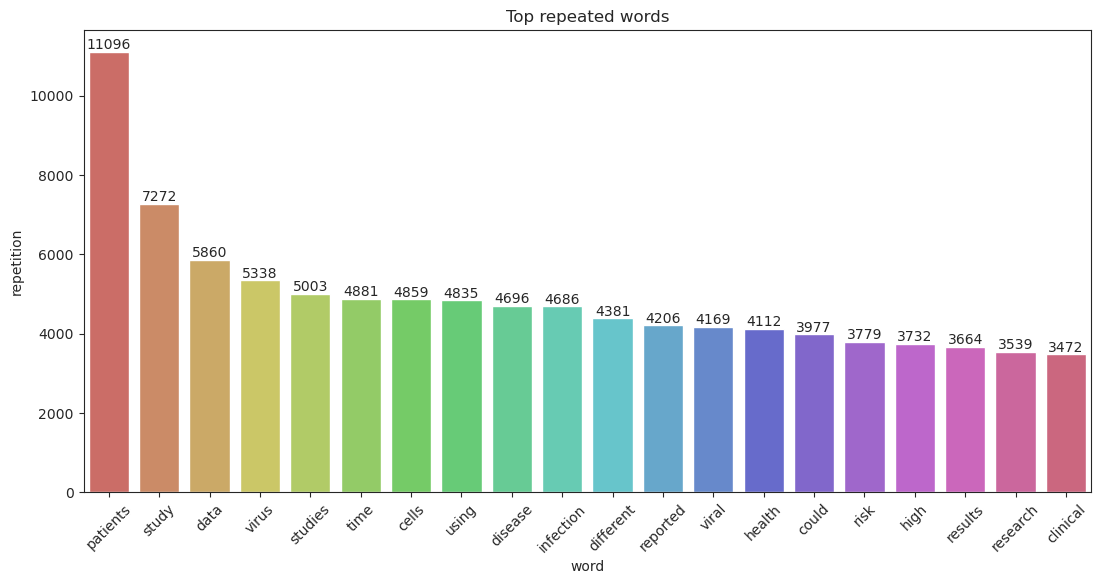

In [44]:
plt.figure(figsize=(13,6))
sns.set_style("ticks")


ax = sns.barplot(data=dfdesc, x = "word", y = 'repetition', palette = 'hls')

xt = plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i,)

title = ax.set_title("Top repeated words")

### 1.4 performance analysis for this task for different number of workers and partitions:

In [8]:
n_workers = [1, 2, 3, 4, 5]
n_partitions=[5, 10, 50, 100, 500]
file_path = '/home/ubuntu/data/Asal.py'



def Clusterf(path):
    warnings.filterwarnings("ignore")
    client = Client()
    for w in n_workers:
        client.close()
        client = None
        cluster = SSHCluster(
            ["localhost",w1, w2],connect_options={"known_hosts": None, "username": "ubuntu", "client_keys": ["~/.ssh/daskM"]}
            ,worker_options={"nthreads": 2, "n_workers": w},
            scheduler_options={"port": 0, "dashboard_address": ":8797"})
        client = Client(cluster)



        globals()['TW_{}'.format(w)] = []
        Ns = n_partitions
        for n in Ns:
            start_time = time.time()
            exec(open(path).read())
            end_time = time.time()
            globals()['Time_{}'.format(n)] = end_time - start_time
            globals()['TW_{}'.format(w)].append(globals()['Time_{}'.format(n)])
            print(f"Execution time: {globals()['Time_{}'.format(n)]:.2f} seconds")

In [9]:
Clusterf(file_path)

2023-07-09 19:20:11,129 - distributed.deploy.ssh - INFO - 2023-07-09 19:20:11,128 - distributed.scheduler - INFO - State start
2023-07-09 19:20:11,132 - distributed.deploy.ssh - INFO - 2023-07-09 19:20:11,131 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:40091
2023-07-09 19:20:12,138 - distributed.deploy.ssh - INFO - 2023-07-09 19:20:12,147 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:35803'
2023-07-09 19:20:12,250 - distributed.deploy.ssh - INFO - 2023-07-09 19:20:12,251 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:36001'
2023-07-09 19:20:12,915 - distributed.deploy.ssh - INFO - 2023-07-09 19:20:12,920 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.100:45689
2023-07-09 19:20:13,043 - distributed.deploy.ssh - INFO - 2023-07-09 19:20:13,043 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.209:37293


Execution time: 69.58 seconds
Execution time: 66.25 seconds
Execution time: 64.78 seconds
Execution time: 82.44 seconds
Execution time: 87.66 seconds


2023-07-09 19:26:25,210 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8797 is already in use.
2023-07-09 19:26:25,212 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-09 19:26:25,213 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 35067 instead
2023-07-09 19:26:25,215 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-09 19:26:25,215 - distributed.deploy.ssh - INFO - 2023-07-09 19:26:25,209 - distributed.scheduler - INFO - State start
2023-07-09 19:26:25,216 - distributed.deploy.ssh - INFO - 2023-07-09 19:26:25,213 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:42283
2023-07-09 19:26:26,787 - distributed.deploy.ssh - INFO - 2023-07-09 19:26:26,785 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:35047'
2023-07-09 19:26:26,794 - distributed.deploy.ssh - INFO - 2023-07-09 19:26:26,793 - distributed.na

Execution time: 55.50 seconds
Execution time: 47.16 seconds
Execution time: 51.71 seconds
Execution time: 57.29 seconds
Execution time: 61.05 seconds


2023-07-09 19:31:01,836 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8797 is already in use.
2023-07-09 19:31:01,838 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-09 19:31:01,839 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 45677 instead
2023-07-09 19:31:01,840 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-09 19:31:01,840 - distributed.deploy.ssh - INFO - 2023-07-09 19:31:01,835 - distributed.scheduler - INFO - State start
2023-07-09 19:31:01,844 - distributed.deploy.ssh - INFO - 2023-07-09 19:31:01,843 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:35291
2023-07-09 19:31:03,476 - distributed.deploy.ssh - INFO - 2023-07-09 19:31:03,461 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:39497'
2023-07-09 19:31:03,489 - distributed.deploy.ssh - INFO - 2023-07-09 19:31:03,479 - distributed.na

Execution time: 41.26 seconds
Execution time: 38.16 seconds
Execution time: 43.97 seconds
Execution time: 48.93 seconds
Execution time: 53.49 seconds


2023-07-09 19:34:51,692 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8797 is already in use.
2023-07-09 19:34:51,694 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-09 19:34:51,695 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 40803 instead
2023-07-09 19:34:51,697 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-09 19:34:51,698 - distributed.deploy.ssh - INFO - 2023-07-09 19:34:51,691 - distributed.scheduler - INFO - State start
2023-07-09 19:34:51,701 - distributed.deploy.ssh - INFO - 2023-07-09 19:34:51,698 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:33975
2023-07-09 19:34:53,316 - distributed.deploy.ssh - INFO - 2023-07-09 19:34:53,306 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:37893'
2023-07-09 19:34:53,332 - distributed.deploy.ssh - INFO - 2023-07-09 19:34:53,322 - distributed.na

Execution time: 40.45 seconds
Execution time: 38.81 seconds
Execution time: 37.18 seconds
Execution time: 46.81 seconds
Execution time: 49.31 seconds


2023-07-09 19:38:28,551 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8797 is already in use.
2023-07-09 19:38:28,554 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-09 19:38:28,555 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 33437 instead
2023-07-09 19:38:28,556 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-09 19:38:28,559 - distributed.deploy.ssh - INFO - 2023-07-09 19:38:28,549 - distributed.scheduler - INFO - State start
2023-07-09 19:38:28,562 - distributed.deploy.ssh - INFO - 2023-07-09 19:38:28,552 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:38189
2023-07-09 19:38:29,654 - distributed.deploy.ssh - INFO - 2023-07-09 19:38:29,634 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:44179'
2023-07-09 19:38:29,665 - distributed.deploy.ssh - INFO - 2023-07-09 19:38:29,644 - distributed.na

Execution time: 39.35 seconds
Execution time: 36.62 seconds
Execution time: 40.39 seconds
Execution time: 46.43 seconds
Execution time: 50.23 seconds


In [11]:
df_0 = pd.DataFrame(
    {"w = 1": TW_1,
     "w = 2": TW_2,
     "w = 3": TW_3,
     "w = 4": TW_4,
     "w = 5": TW_5
    }, index = n_partitions)


df_0.to_csv('/home/ubuntu/data/Asal.csv')

In [12]:
df_0= pd.read_csv('/home/ubuntu/data/Asal.csv')
df_0.columns = df_0.columns.str.replace('Unnamed: 0', 'Partitions')
df_0.set_index('Partitions', inplace = True)
df_0

,w = 1,w = 2,w = 3,w = 4,w = 5
Partitions,,,,,
5,69.583184,55.503254,41.258466,40.454089,39.348256
10,66.253494,47.157115,38.155697,38.805129,36.615921
50,64.783677,51.708974,43.967601,37.176444,40.387531
100,82.444761,57.293133,48.926276,46.809293,46.426561
500,87.660313,61.052886,53.489071,49.312789,50.232770


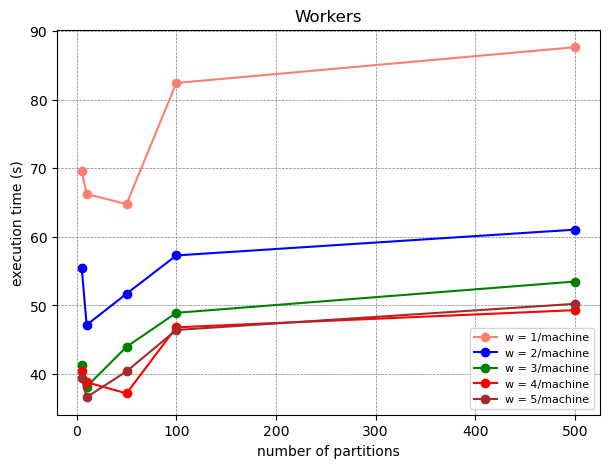

In [13]:
plt.figure(figsize=(7,5))

plt.plot(df_0.index, df_0['w = 1'], marker = 'o', c = 'salmon', label = 'w = 1/machine')
plt.plot(df_0.index, df_0['w = 2'], marker = 'o', c = 'blue', label = 'w = 2/machine')
plt.plot(df_0.index, df_0['w = 3'], marker = 'o', c = 'green', label = 'w = 3/machine')
plt.plot(df_0.index, df_0['w = 4'], marker = 'o', c = 'red', label = 'w = 4/machine')
plt.plot(df_0.index, df_0['w = 5'], marker = 'o', c = 'brown', label = 'w = 5/machine')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.xlabel('number of partitions')
plt.ylabel('execution time (s)')
plt.title('Workers')
plt.legend(loc = 'lower right', fontsize = 8)
plt.show()

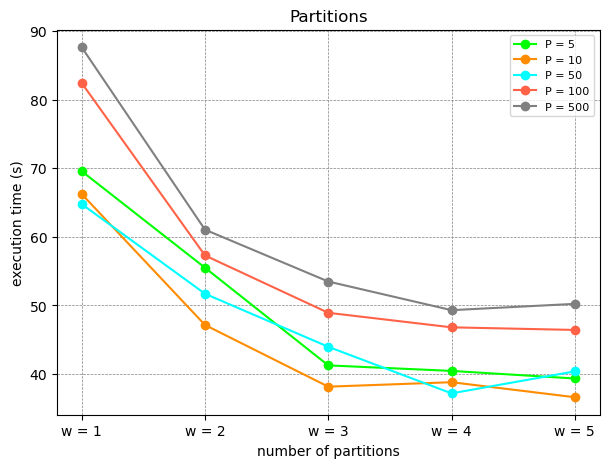

In [14]:
plt.figure(figsize=(7,5))

plt.plot(df_0.columns, df_0.iloc[0, :], marker = 'o', c = 'lime', label = 'P = 5')
plt.plot(df_0.columns, df_0.iloc[1, :], marker = 'o', c = 'darkorange', label = 'P = 10')
plt.plot(df_0.columns, df_0.iloc[2, :], marker = 'o', c = 'aqua', label = 'P = 50')
plt.plot(df_0.columns, df_0.iloc[3, :], marker = 'o', c = 'tomato', label = 'P = 100')
plt.plot(df_0.columns, df_0.iloc[4, :], marker = 'o', c = 'gray', label = 'P = 500')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.xlabel('number of partitions')
plt.ylabel('execution time (s)')
plt.title('Partitions')
plt.legend(loc = 'upper right', fontsize = 8)
plt.show()

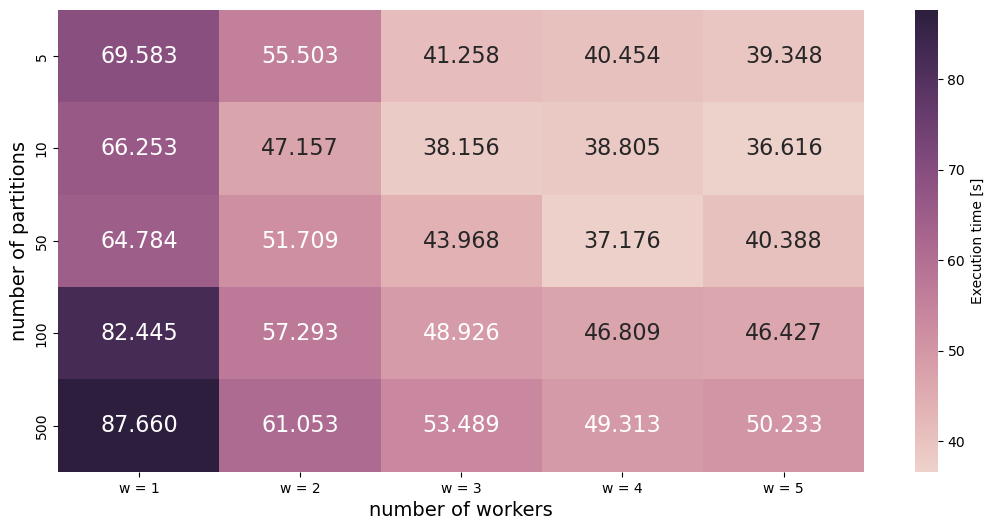

In [15]:
plt.figure(figsize=(13,6))
sn.heatmap(df_0, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap=sns.cubehelix_palette(as_cmap=True))

plt.xlabel('number of workers',fontsize=14)
plt.ylabel('number of partitions',fontsize=14)
plt.show()
plt.style.use('default')

---

---

---

### 1.5 Sentiment analysis:

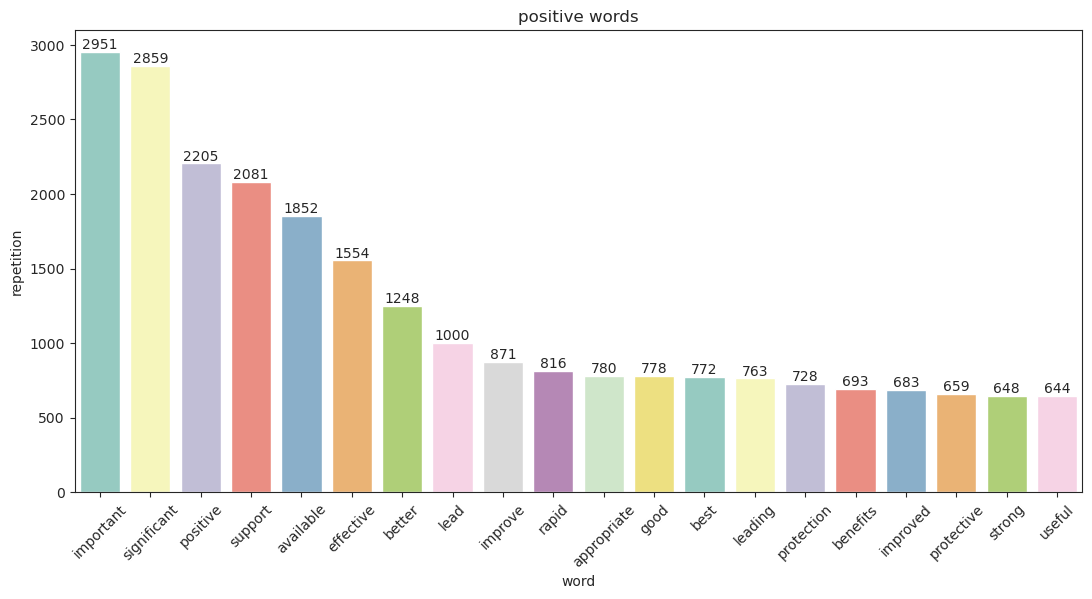

In [46]:
#positive words:
plt.figure(figsize=(13,6))
positive_words = set(opinion_lexicon.positive())


# we dropped annoying positive words that have double meaning like : well, patient, like.
# We don't know why work should be a positive word ! :))) , we deleted work too
dfsent = df[df['word'].isin(positive_words)].sort_values(by = "repetition", ascending =False).head(100).drop([40, 683, 616, 2904 ])




sns.set_style("ticks")


ax = sns.barplot(data=dfsent.head(20), x = "word", y = 'repetition', palette = 'Set3')

xt = plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i,) 
title = ax.set_title("positive words")

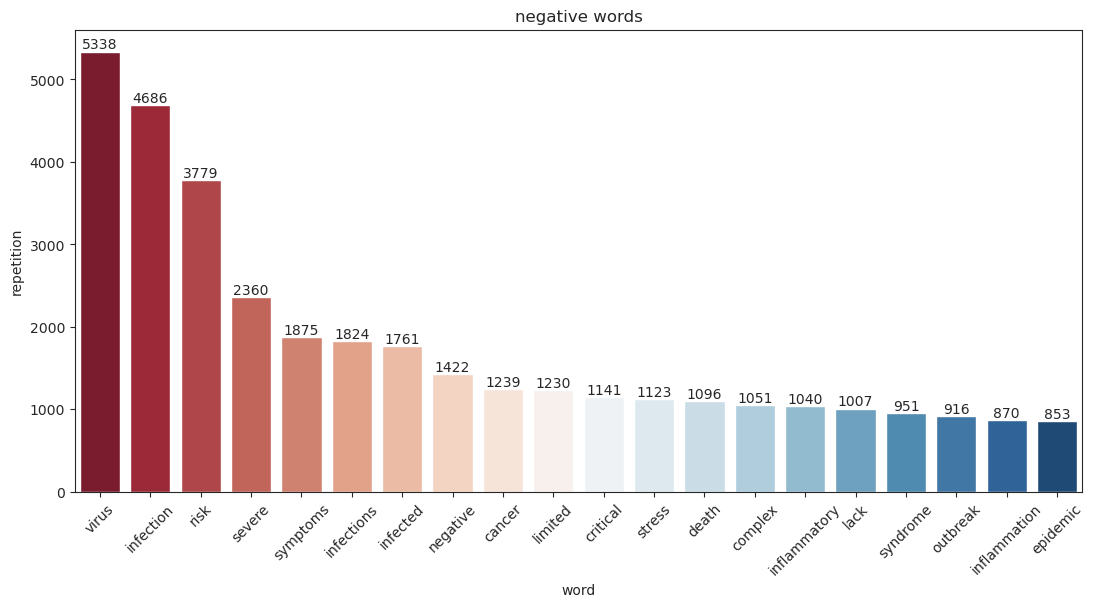

In [47]:
#Negative words

plt.figure(figsize=(13,6))
negative_words = set(opinion_lexicon.negative())


dfsentn = df[df['word'].isin(negative_words)].sort_values(by = "repetition", ascending =False).head(100)


sns.set_style("ticks")


ax = sns.barplot(data=dfsentn.head(20), x = "word", y = 'repetition', palette = 'RdBu')

xt = plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i,) 
title = ax.set_title("negative words")

## 2. Which best-represented countries/universities in the research?

In [48]:
filenames = os.path.join('/home/ubuntu/data/one_liner/','*.json')
#if the data is not flattened and is nested this line will have a problem loading the lines.

#partitioned papers:
partp = db.read_text(filenames).map(json.loads).repartition(10) 
#partp.take(1)

In [49]:
#extracting authors from the metadata in each paper to see the information about them:
authors = partp.pluck('metadata').pluck('authors')
authors.flatten().take(1)

({'first': 'Ko',
  'middle': [],
  'last': 'Konno',
  'suffix': '',
  'affiliation': {'laboratory': '',
   'institution': 'Bangor University',
   'location': {'postCode': 'LL57 2UW',
    'settlement': 'Gwynedd',
    'country': 'UK'}},
  'email': ''},)

### 2.1 Countries:

**Country_dataframe function:**

This function takes care of many things. For example, we had country names like ```"China"``` and ```"China, China. China"```, or ```"Italy, Padova"``` and ```"Italy"```. Of course we did not want to multiple counts for a single country due to name differences. Therefore, we tried as much as we could to make the country names very uniform. This function make the records ready for the dataframe.



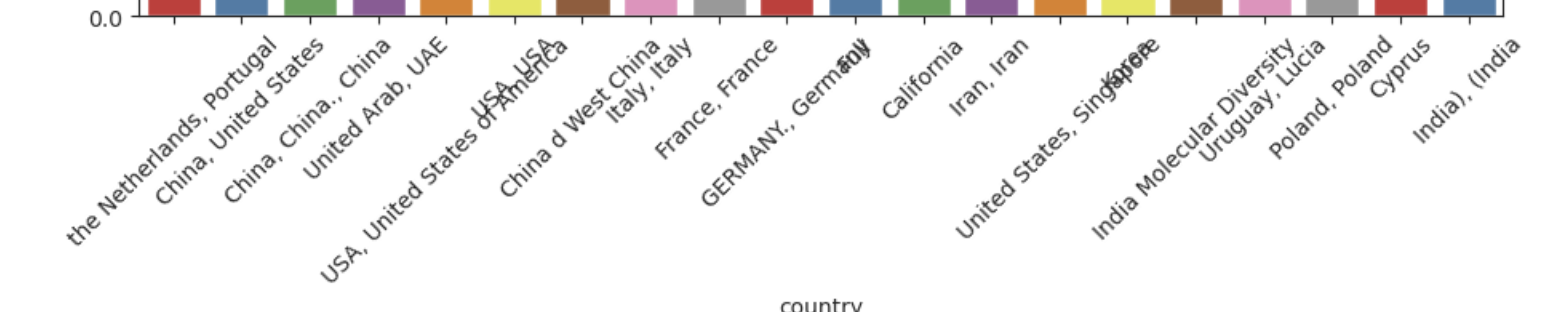

In [50]:
# Get a list of all country names in three ways(they share the same index):
names = [country.name.upper() for country in pycountry.countries] # the complete name
list2 = [country.alpha_2.upper() for country in pycountry.countries] # the three letter name
list3 = [country.alpha_3.upper() for country in pycountry.countries] # the two letter name

In [51]:

def country_dataframe(chunk):
    country = ''

    if 'country' in chunk['affiliation'].keys():
        if chunk['affiliation']['country'] == '':
            country = "unknown"
        else:
            country = chunk['affiliation']['country'].upper()
            tokenizer = RegexpTokenizer(r'\w+')
            element = tokenizer.tokenize(country)
            if len(element) == 1:
                country = elemet[0].upper()
            
            
            elif len(element) == 2:
                if element[0].upper() == element[1].upper():
                    country = element[0].upper()
                else:
                    if element[0].upper() in names:
                        country = element[0].upper()
                    elif element[0].upper() in list2:
                        index = list2.index(element[0])
                        country = names[index]
                    elif element[0].upper() in list3:
                        index = list3.index(element[0])
                        country = names[element[0]]
                    
                    
                    elif element[1].upper() in names:
                        country = element[1].upper()
                    elif element[1].upper() in list2:
                        index = list2.index(element[1])
                        country = names[index]
                    elif element[1].upper() in list3:
                        index = list3.index(element[1])
                        country = names[element[1]]
                                    
            elif len(element) == 3:
                if element[0].upper() == element[1].upper() == element[2].upper:
                    country = element[0].upper()
                    
            else:
                country = "unknown"
                        
                    
                    
            
        
    elif 'location' in chunk['affiliation'].keys():
        if 'country' in chunk['affiliation']['location'].keys():
            if chunk['affiliation']['location']['country'] == '':
                country = "unknown"
            else :
                country = chunk['affiliation']['location']['country']
                tokenizer = RegexpTokenizer(r'\w+')
                element = tokenizer.tokenize(country)
            if len(element) == 1:
                country = element[0].upper()
                
            elif len(element) == 2:
                if element[0].upper() == element[1].upper():
                    country = element[0].upper()
                else:
                    if element[0].upper() in names:
                        country = element[0].upper()
                    elif element[0].upper() in list2:
                        index = list2.index(element[0])
                        country = names[index]
                    elif element[0].upper() in list3:
                        index = list3.index(element[0])
                        country = names[element[0]]
                        
                    elif element[1].upper() in names:
                        country = element[1].upper()
                    elif element[1].upper() in list2:
                        index = list2.index(element[1])
                        country = names[index]
                    elif element[1].upper() in list3:
                        index = list3.index(element[1])
                        country = names[element[1]]
                        
                    
                        
                        
            elif len(element) == 3:
                if element[0].upper() == element[1].upper() == element[2].upper:
                    country = element[0].upper()
            
            else :
                country = "unknown"             
                
        else:
            country = "unknown"
    else:
        country = "unknown"
        
    if country == '': country = 'unkown'
    return {"name": chunk['first'], 'surname': chunk['last'], 'country': country}
    
    
#def University_dataframe(chunk):
    
    
    

In [52]:
df_c = authors.flatten().map(country_dataframe).to_dataframe()
df_c.head(5)

,name,surname,country
0,Ko,Konno,UK
1,Samantha,Cheng,USA
2,Jacqualyn,Eales,unknown
3,Geoff,Frampton,UK
4,Christian,Kohl,GERMANY


### Active Countries:

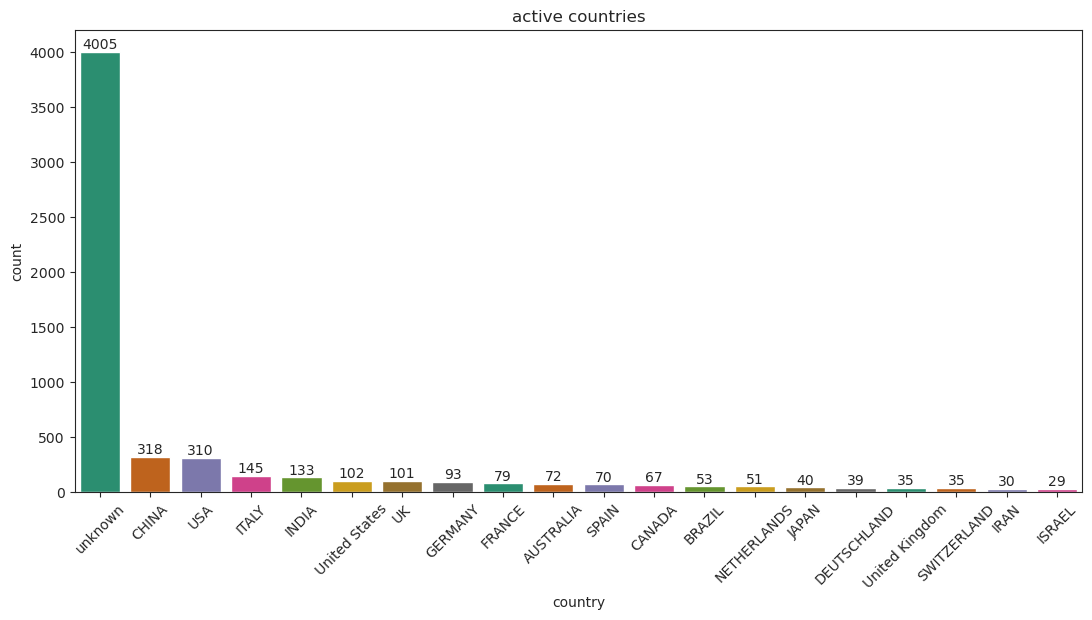

In [54]:
#grouping by the countries and again putting them back to a dataframe, which is sorted in desc order.
plt.figure(figsize=(13,6))
active_countries = df_c.groupby('country').size().to_frame(name = 'count').sort_values(by = 'count', ascending = False).head(20)



sns.set_style("ticks")


ax = sns.barplot(data=active_countries, x = active_countries.index, y = 'count', palette = 'Dark2')

xt = plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i,) 
title = ax.set_title("active countries")

### 2.2 Universities:

In [55]:
def uni_dataframe(chunk):
    
    uni = ''
    if 'institution' in chunk['affiliation'].keys():
        if chunk['affiliation']['institution'] == '':
            uni = np.nan
        else :
            uni= chunk['affiliation']['institution'].upper()
        

        
    else: 
        uni= np.nan
        
    
        
    return{'name': chunk['first'], 'last': chunk['last'], 'University': uni }

In [56]:
# This time we decided we don't want the unknown countries counts on our plot, so we dropped them :)


df_uni = authors.flatten().map(uni_dataframe).to_dataframe().dropna()
df_uni.head()

,name,last,University
0,Ko,Konno,BANGOR UNIVERSITY
1,Samantha,Cheng,AMERICAN MUSEUM OF NATURAL HISTORY
2,Jacqualyn,Eales,UNIVERSITY OF EXETER
3,Geoff,Frampton,UNIVERSITY OF SOUTHAMPTON
4,Christian,Kohl,JULIUS KÜHN-INSTITUTE


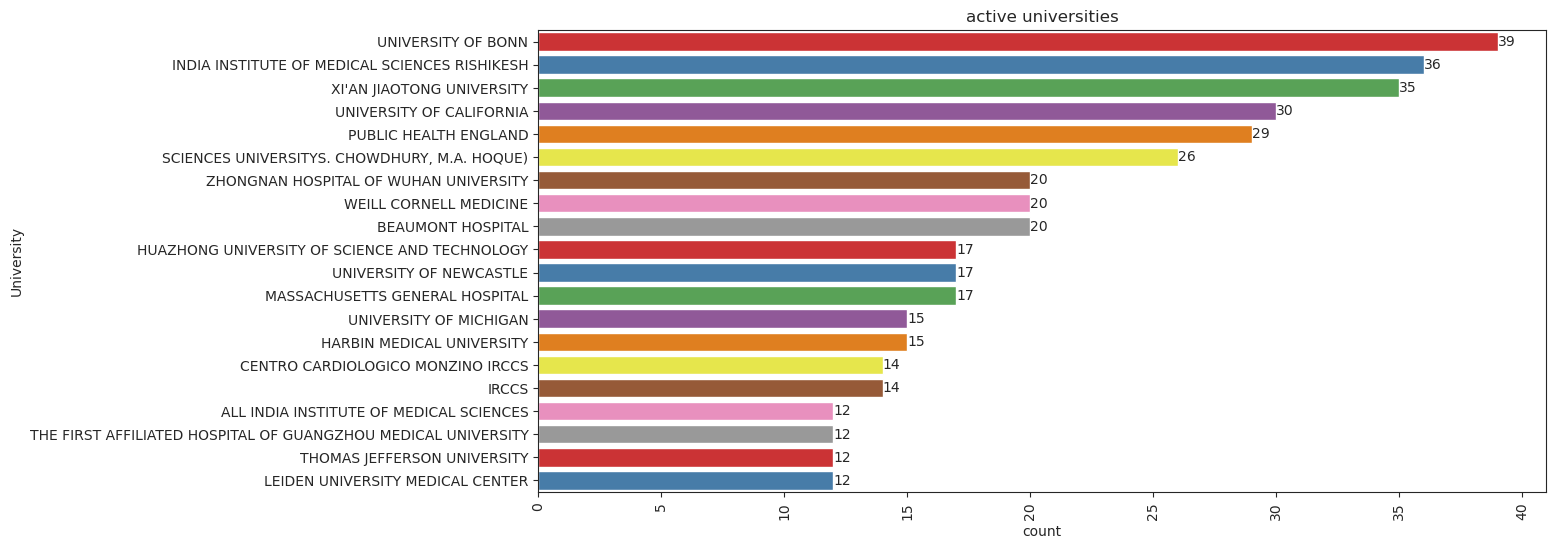

In [57]:
# we grouped the dataframe by the universities and count their repetition.
plt.figure(figsize=(13,6))
active_uni = df_uni.groupby('University').size().to_frame(name = 'count').sort_values(by = 'count', ascending = False).head(20)



sns.set_style("ticks")


ax = sns.barplot(data=active_uni, x = 'count', y = active_uni.index , palette = 'Set1', orient='horizontal')

xt = plt.xticks(rotation=90)
for i in ax.containers:
    ax.bar_label(i,) 
title = ax.set_title("active universities")






### 2.3 performance analysis for this task for different number of workers and partitions:

In [ ]:
n_workers = [1, 2, 3, 4, 5]
n_partitions=[5, 10, 50, 100, 500]
file_path = '/home/ubuntu/data/Elahe.py'



def Clusterf(path):
    warnings.filterwarnings("ignore")
    client = Client()
    for w in n_workers:
        client.close()
        client = None
        cluster = SSHCluster(
            ["localhost",w1, w2],connect_options={"known_hosts": None, "username": "ubuntu", "client_keys": ["~/.ssh/daskM"]}
            ,worker_options={"nthreads": 2, "n_workers": w},
            scheduler_options={"port": 0, "dashboard_address": ":8797"})
        client = Client(cluster)



        globals()['TW_{}'.format(w)] = []
        Ns = n_partitions
        for n in Ns:
            start_time = time.time()
            exec(open(path).read())
            end_time = time.time()
            globals()['Time_{}'.format(n)] = end_time - start_time
            globals()['TW_{}'.format(w)].append(globals()['Time_{}'.format(n)])
            print(f"Execution time: {globals()['Time_{}'.format(n)]:.2f} seconds")

In [ ]:
Clusterf(file_path)

In [ ]:
df = pd.DataFrame(
    {"w = 1": TW_1,
     "w = 2": TW_2,
     "w = 3": TW_3,
     "w = 4": TW_4,
     "w = 5": TW_5
    }, index = n_partitions)


df.to_csv('/home/ubuntu/data/Elahe.csv')

In [58]:
df_1= pd.read_csv('/home/ubuntu/data/Elahe.csv')
df_1.columns = df_1.columns.str.replace('Unnamed: 0', 'Partitions')
df_1.set_index('Partitions', inplace = True)
df_1

,w = 1,w = 2,w = 3,w = 4,w = 5
Partitions,,,,,
5,105.479917,70.875878,69.101434,57.582170,58.116851
10,96.365402,62.603328,58.697345,57.672455,49.992822
50,96.628409,65.807216,53.442491,48.584511,49.009606
100,102.356847,71.977475,58.216221,56.704766,57.771595
500,118.846079,84.608711,64.739302,57.657731,67.251959


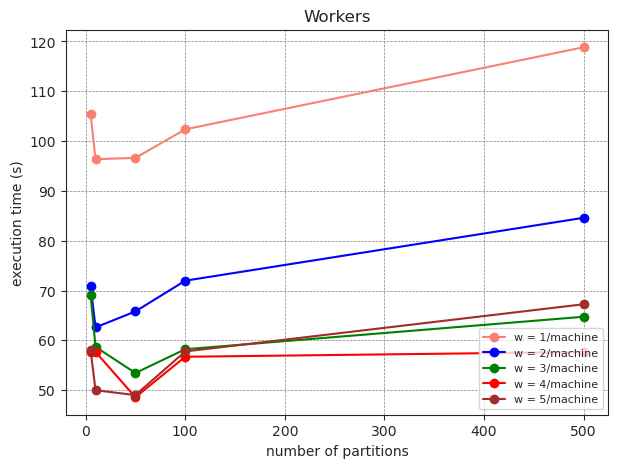

In [59]:
plt.figure(figsize=(7,5))

plt.plot(df_1.index, df_1['w = 1'], marker = 'o', c = 'salmon', label = 'w = 1/machine')
plt.plot(df_1.index, df_1['w = 2'], marker = 'o', c = 'blue', label = 'w = 2/machine')
plt.plot(df_1.index, df_1['w = 3'], marker = 'o', c = 'green', label = 'w = 3/machine')
plt.plot(df_1.index, df_1['w = 4'], marker = 'o', c = 'red', label = 'w = 4/machine')
plt.plot(df_1.index, df_1['w = 5'], marker = 'o', c = 'brown', label = 'w = 5/machine')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.xlabel('number of partitions')
plt.ylabel('execution time (s)')
plt.title('Workers')
plt.legend(loc = 'lower right', fontsize = 8)
plt.show()

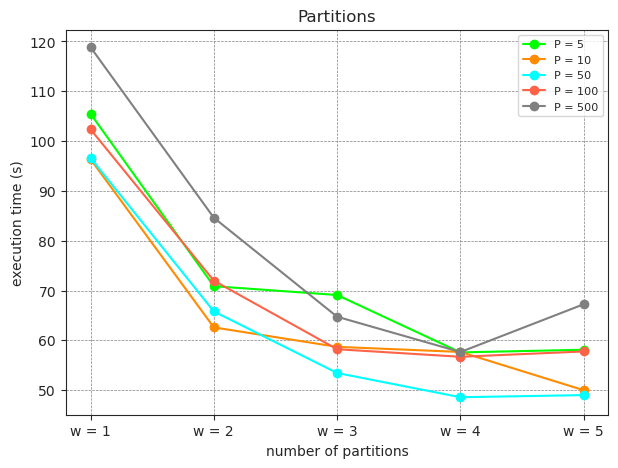

In [60]:
plt.figure(figsize=(7,5))

plt.plot(df_1.columns, df_1.iloc[0, :], marker = 'o', c = 'lime', label = 'P = 5')
plt.plot(df_1.columns, df_1.iloc[1, :], marker = 'o', c = 'darkorange', label = 'P = 10')
plt.plot(df_1.columns, df_1.iloc[2, :], marker = 'o', c = 'aqua', label = 'P = 50')
plt.plot(df_1.columns, df_1.iloc[3, :], marker = 'o', c = 'tomato', label = 'P = 100')
plt.plot(df_1.columns, df_1.iloc[4, :], marker = 'o', c = 'gray', label = 'P = 500')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.xlabel('number of partitions')
plt.ylabel('execution time (s)')
plt.title('Partitions')
plt.legend(loc = 'upper right', fontsize = 8)
plt.show()

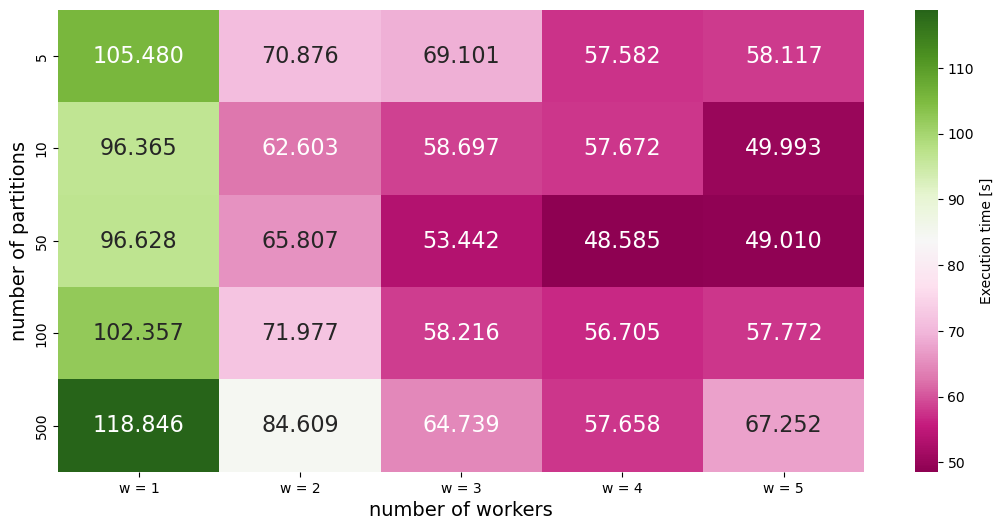

In [62]:
plt.figure(figsize=(13,6))
sn.heatmap(df_1, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap="PiYG")

plt.xlabel('number of workers',fontsize=14)
plt.ylabel('number of partitions',fontsize=14)
plt.show()
plt.style.use('default')

---

---

---

## 3. Get the embedding for the title of the papers:


Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

What are word embeddings exactly? Loosely speaking, they are vector representations of a particular word. Having said this, what follows is how do we generate them? More importantly, how do they capture the context?

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

**Why do we need this method ?**


Consider the following similar sentences: Have a good day and Have a great day. They hardly have different meaning. If we construct an exhaustive vocabulary (let’s call it V), it would have `V = {Have, a, good, great, day}.`

Now, let us create a one-hot encoded vector for each of these words in V. Length of our one-hot encoded vector would be equal to the size of V (=5). We would have a vector of zeros except for the element at the index representing the corresponding word in the vocabulary. That particular element would be one. The encodings below would explain this better.

`Have = [1,0,0,0,0]; a=[0,1,0,0,0] ; good=[0,0,1,0,0] ; great=[0,0,0,1,0] ; day=[0,0,0,0,1] `

**note : all the vectors above are transposed**

If we try to visualize these encodings, we can think of a 5 dimensional space, where each word occupies one of the dimensions and has nothing to do with the rest (no projection along the other dimensions). This means ‘good’ and ‘great’ are as different as ‘day’ and ‘have’, which is not true.

Our objective is to have words with similar context occupy close spatial positions. Mathematically, the cosine of the angle between such vectors should be close to 1, i.e. angle close to 0.

### 3.1 The NLP model:

In [10]:
from dask.distributed import Client, LocalCluster
from gensim.models import KeyedVectors
import seaborn as sns
import dask.bag as db
import os
import json
import numpy as np
import time
import io
import time
import dask.array as da

In [11]:
fname = '/home/ubuntu/data/wiki-news-300d-1M.vec'
filenames = os.path.join('/home/ubuntu/data/one_liner/','*.json')

In [12]:
#load the emmbeded words from pre-trained model
start=time.time()

word_vectors = KeyedVectors.load_word2vec_format(fname)
stop=time.time()

print("time(min):",(stop-start)/60)

time(min): 2.0425374348958334


In [13]:
word_vectors['hello']

array([-1.920e-01,  1.544e-01,  4.670e-02,  5.920e-02,  1.369e-01,
       -7.720e-02, -3.840e-02,  5.370e-02,  1.435e-01, -1.353e-01,
       -5.300e-02, -6.680e-02,  1.850e-02,  8.730e-02,  9.030e-02,
        1.663e-01,  3.500e-03, -2.102e-01,  2.010e-01, -2.490e-02,
       -2.790e-02, -3.241e-01, -6.600e-03, -2.640e-02, -1.628e-01,
       -1.094e-01, -8.820e-02,  9.700e-03,  1.228e-01,  5.900e-03,
       -5.100e-02,  6.490e-02,  1.577e-01,  1.740e-02,  9.910e-02,
        1.328e-01, -5.860e-02,  1.814e-01, -9.800e-03,  1.877e-01,
        5.180e-02, -6.970e-02, -6.290e-02, -1.981e-01, -1.373e-01,
       -8.110e-02, -6.310e-02, -6.390e-02,  1.244e-01, -2.470e-02,
        2.250e-02, -3.174e-01, -8.462e-01, -1.248e-01,  8.240e-02,
        2.120e-02,  9.960e-02, -3.440e-02,  1.383e-01, -9.830e-02,
        1.637e-01, -1.906e-01, -1.969e-01,  1.473e-01,  1.318e-01,
       -7.000e-02,  3.040e-02, -3.450e-02,  1.507e-01, -1.786e-01,
        1.038e-01, -3.500e-03, -9.300e-02,  1.255e-01,  1.431e

In [14]:
# 300 dimensions
len(word_vectors['infection'])

300

In [15]:
b = db.read_text(filenames).map(json.loads).repartition(npartitions=10)

In [16]:
def diction(record):
    return {"paper_id": record['paper_id'],"title": record['metadata']['title']}

In [17]:
# if the title is not empty keep it, otherwise drop it.
data = b.map(diction).filter(lambda record: bool(record['title'])).compute()

In [18]:
data[0]

{'paper_id': '0032acf4de2905b7ce9d1b0835e5258a0cbbabf4',
 'title': 'The CEEDER database of evidence reviews: An open-access evidence service for researchers and decision-makers'}

In [19]:
# we have to take to account the fact that some words weren't in the model, maybe they are rarely used.
def embed(text, model):
    text_split = text.lower().split() # we used lower case to make 
    words_embedded=[]

    for words in text_split:
        try:
            words_embedded.append( model[words])
        except:
            pass  
   
    return words_embedded

In [20]:
def id_title_model(record, model):
    return{
        "paper_id": record["paper_id"],
        "title": embed(record['title'], model)
    }

In [21]:
titles_embedded = [id_title_model(items,  word_vectors) for items in data]

In [77]:
#titles_embedded[0]['title']

In [22]:
titles = db.from_sequence(titles_embedded)

In [78]:
#titles.take(1)[0]['title']

### 3.2 The Cosine similarity:


we decided to use two ways of calculating cosine similarity:

1. compare every single word of a title to all words in another title. (computationally demanding)

2. compare each word with the same position in the title.


#### 3.2.1 First method:

In [21]:
#test #playing around with cosine similarity.

cos = np.inner(word_vectors['hate'], word_vectors['shoes'] )/(np.linalg.norm(word_vectors['hate']) * np.linalg.norm(word_vectors['shoes']))
cos

0.29617622

This cosine similarity we have used is word by word between two titles, and each word in title_1 is compared to every word in title_2, to make sure that we grasp the most percise similarity between them. 


as it is shown above in `titles.take(1)[0]['title']` for each title we have a list of arrays. that is why the inputs of the Cosine function should be lists of vectors.

In [23]:
def Cosine(listvec1, listvec2):

    
    
    sim_list = []
    if np.array_equal(listvec1, listvec2):
        sim_list.append(1)
    
    else:
        for vec1 in listvec1:
            for vec2 in listvec2:
                vec1_norm = np.linalg.norm(vec1)
                vec2_norm = np.linalg.norm(vec2)
                cos_sim = np.inner(vec1, vec2)/(vec1_norm * vec2_norm)
                sim_list.append(cos_sim)
    return np.median(sim_list)
    


In [25]:
Cosine(titles_embedded[0]['title'], titles_embedded[0]['title'])

1.0

In [26]:
Cosine(titles_embedded[0]['title'], titles_embedded[1]['title'])

0.35423654

In [24]:
def make_sim_bag(reco):

        c= Cosine(reco[0]['title'], reco[1]['title'])

        return {
             "Paper1:": reco[0]['paper_id'],
             "Paper2:": reco[1]['paper_id'],
             "Similarity": c
}

   

In [28]:
# list: [word1_arr, word2_array, ..... ]

len(titles_embedded)




914

**manual partition for Cosine Similarity on all papers:**

the problem arises when we want to calculate the similarity between 994 papers. it means that the first paper should be compared to 994 papers, the second to the 993 papers and so on. This is very computationally demanding; therefore, we decided to ```chunck down``` the papers into small parts and delete them from the memory after calculating the similarity in order to avoid useless overhead in our memory.

However, we have to figure out which ```chunk size``` is suitable for our computation. Very small chunks do not use the entire **power** of CPUs, while very large chunks kill the kernel due to large computation and consequent **huge memory usage**.


So we measured the time and for a single chunk with multiple sizes and monitored the performance of the workers and their CPUs to see which size is more suitable for this calculations. After finding the best size we are going to chunk down all papers, in order to manage our computation.

In [87]:
%%time

# cosine similarity between paper 0 and first 10 papers.

part1 = (db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in [0] for j in range(10) ])
                .repartition(8).map(make_sim_bag).compute())

worker_addresses = list(c.scheduler_info()["workers"].keys())

for worker_address in worker_addresses:
    worker_info = c.scheduler_info()["workers"][worker_address]
    cpu_usage = worker_info["metrics"]["cpu"]
    print(f"Worker {worker_address} CPU Usage: {cpu_usage}")

part1
del part1

Worker tcp://10.67.22.100:38817 CPU Usage: 2.0
Worker tcp://10.67.22.100:45631 CPU Usage: 4.0
Worker tcp://10.67.22.209:43387 CPU Usage: 4.0
Worker tcp://10.67.22.209:46567 CPU Usage: 2.0
CPU times: user 313 ms, sys: 0 ns, total: 313 ms
Wall time: 447 ms


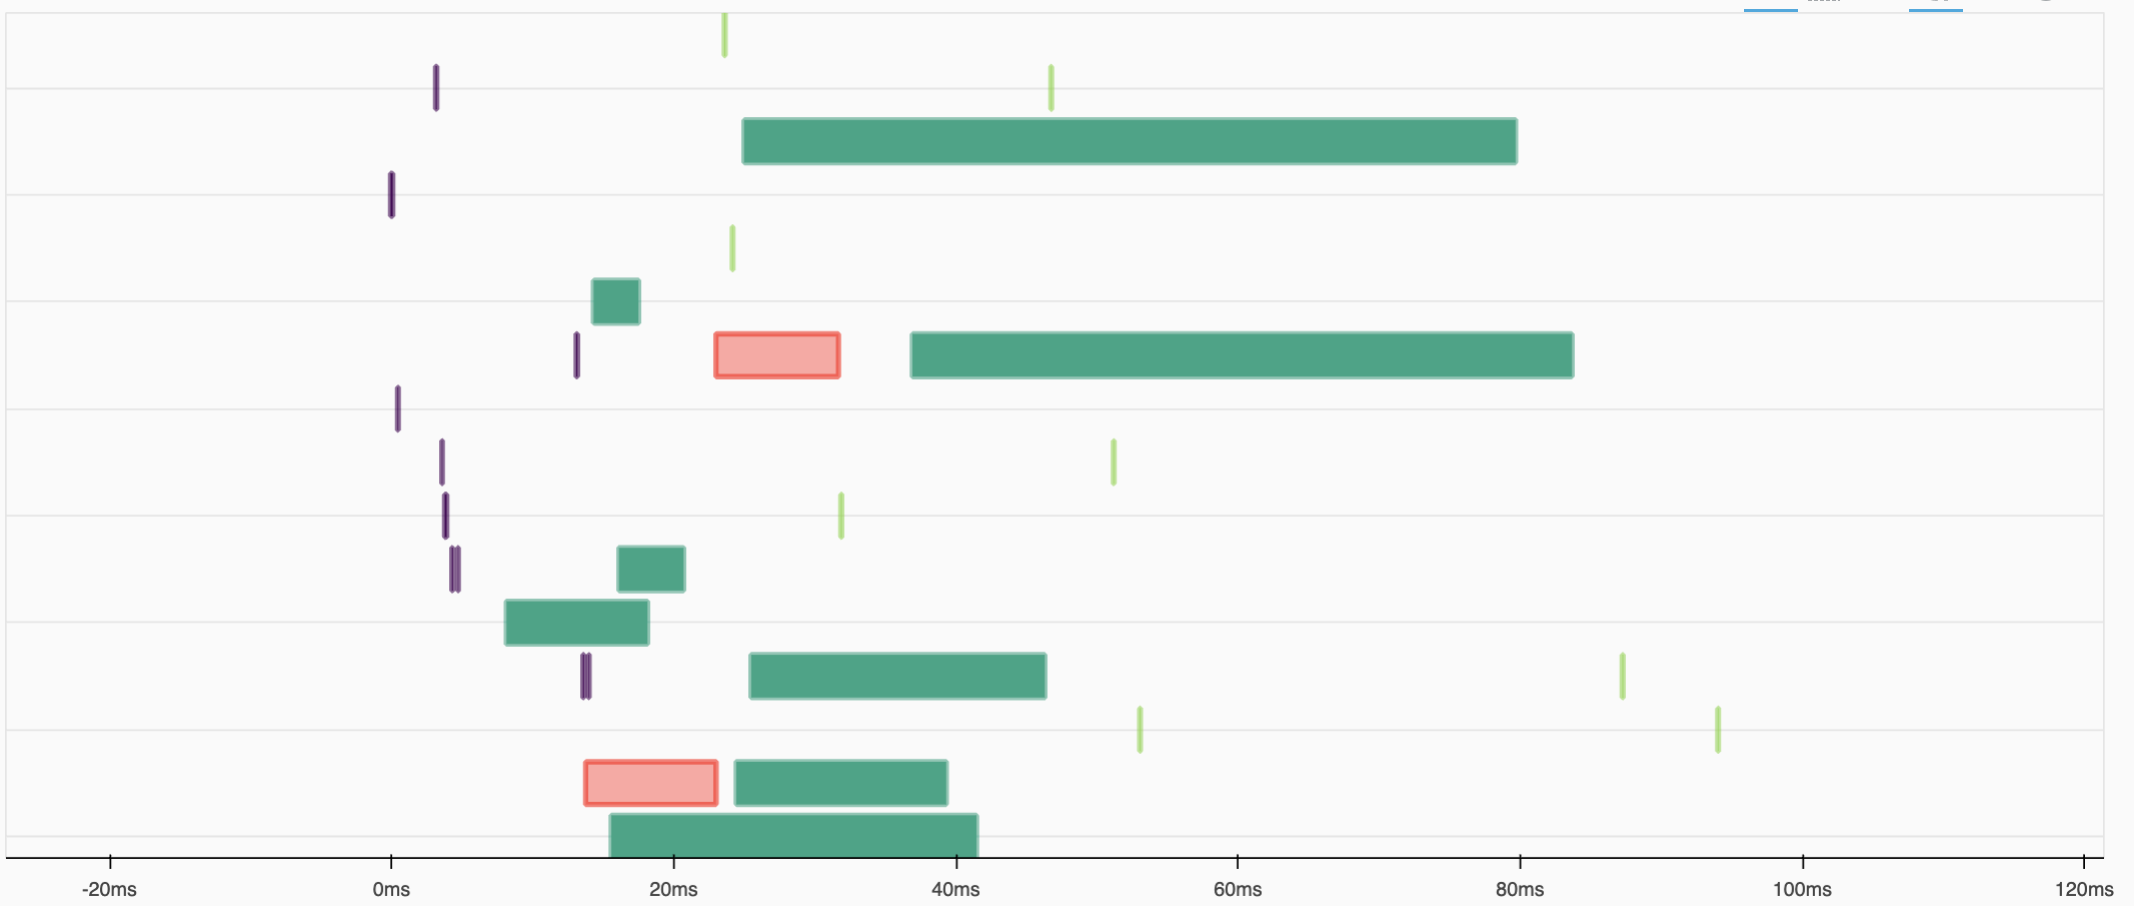

In [88]:
%%time

# cosine similarity between paper 0 and first 100 papers.

part1 = (db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in [0] for j in range(100) ])
                .repartition(8).map(make_sim_bag).compute())

worker_addresses = list(c.scheduler_info()["workers"].keys())

for worker_address in worker_addresses:
    worker_info = c.scheduler_info()["workers"][worker_address]
    cpu_usage = worker_info["metrics"]["cpu"]
    print(f"Worker {worker_address} CPU Usage: {cpu_usage}")

part1
del part1

Worker tcp://10.67.22.100:38817 CPU Usage: 6.0
Worker tcp://10.67.22.100:45631 CPU Usage: 2.0
Worker tcp://10.67.22.209:43387 CPU Usage: 2.0
Worker tcp://10.67.22.209:46567 CPU Usage: 2.0
CPU times: user 3.08 s, sys: 11.1 ms, total: 3.09 s
Wall time: 3.7 s


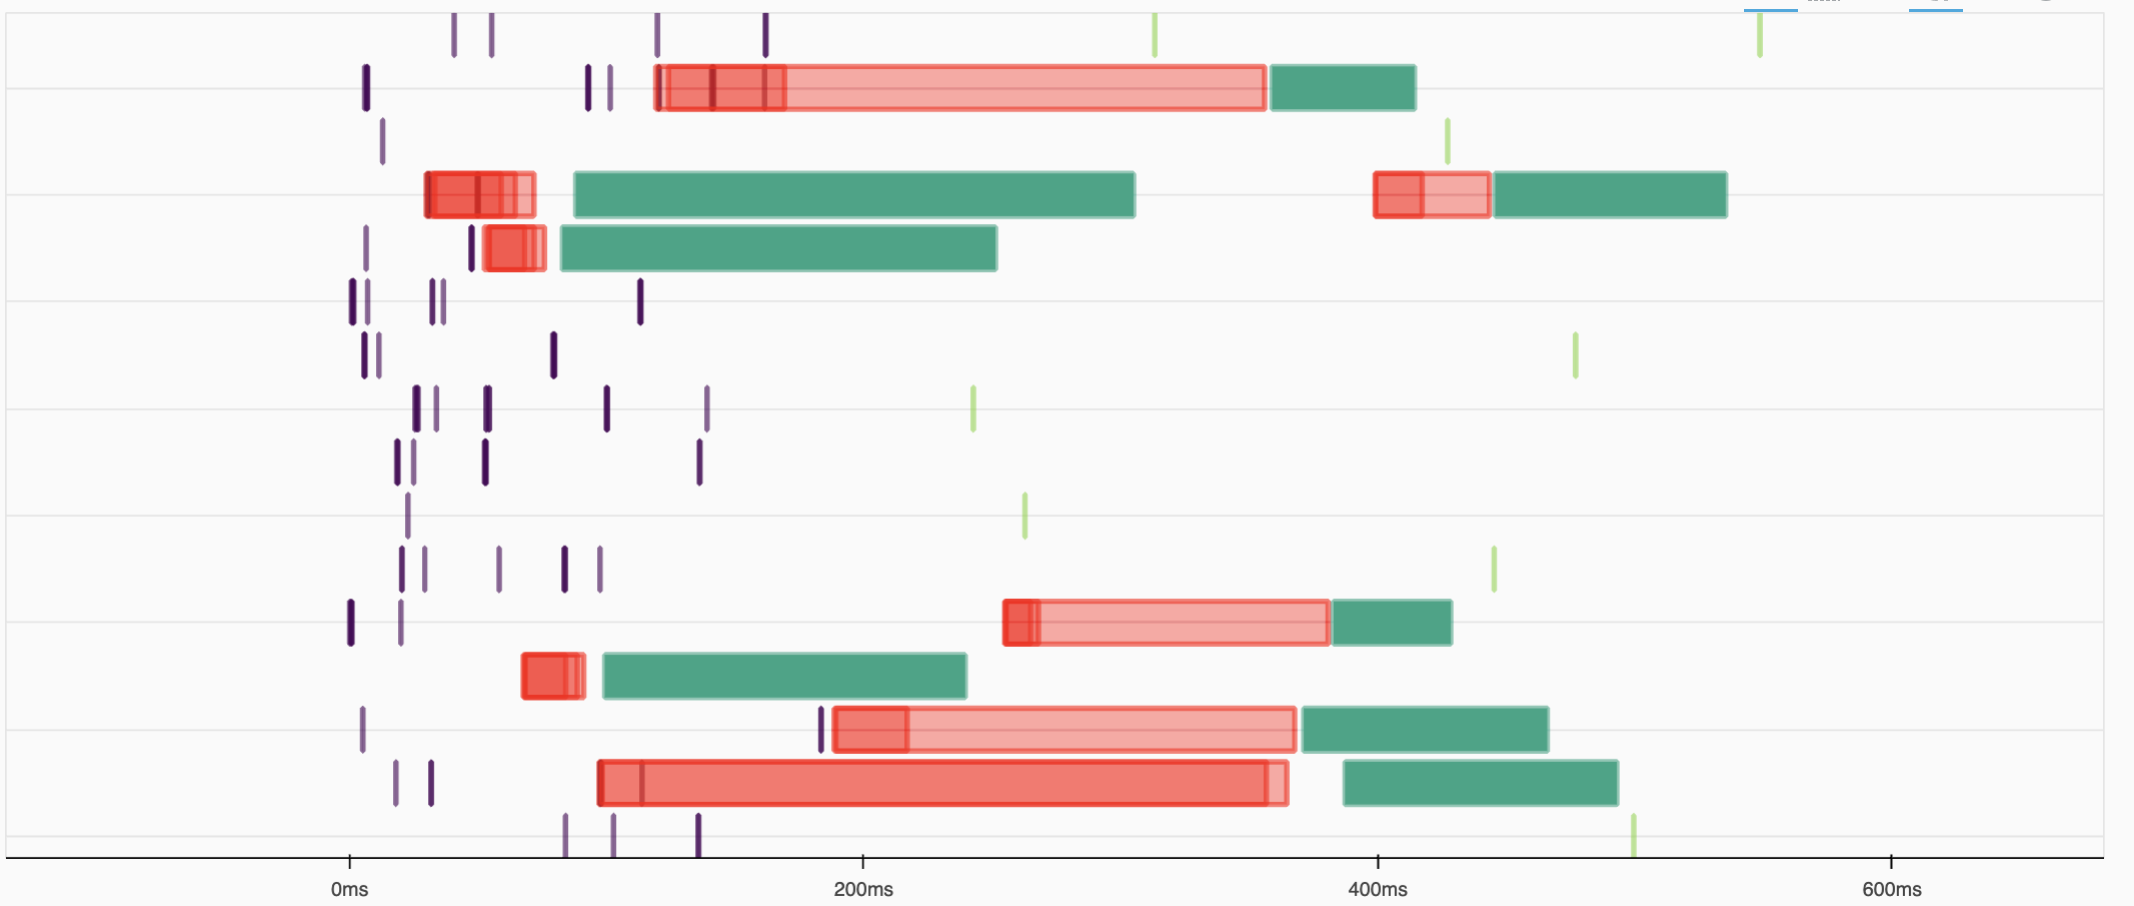

In [89]:
%%time

# cosine similarity between first 20 papers with each other.

part3 =(db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in range(10) for j in range(10) ])
                .repartition(8).map(make_sim_bag).compute())
worker_addresses = list(c.scheduler_info()["workers"].keys())

for worker_address in worker_addresses:
    worker_info = c.scheduler_info()["workers"][worker_address]
    cpu_usage = worker_info["metrics"]["cpu"]
    print(f"Worker {worker_address} CPU Usage: {cpu_usage}")


del part3

Worker tcp://10.67.22.100:38817 CPU Usage: 4.0
Worker tcp://10.67.22.100:45631 CPU Usage: 2.0
Worker tcp://10.67.22.209:43387 CPU Usage: 2.0
Worker tcp://10.67.22.209:46567 CPU Usage: 4.0
CPU times: user 2.85 s, sys: 31.2 ms, total: 2.88 s
Wall time: 3.39 s


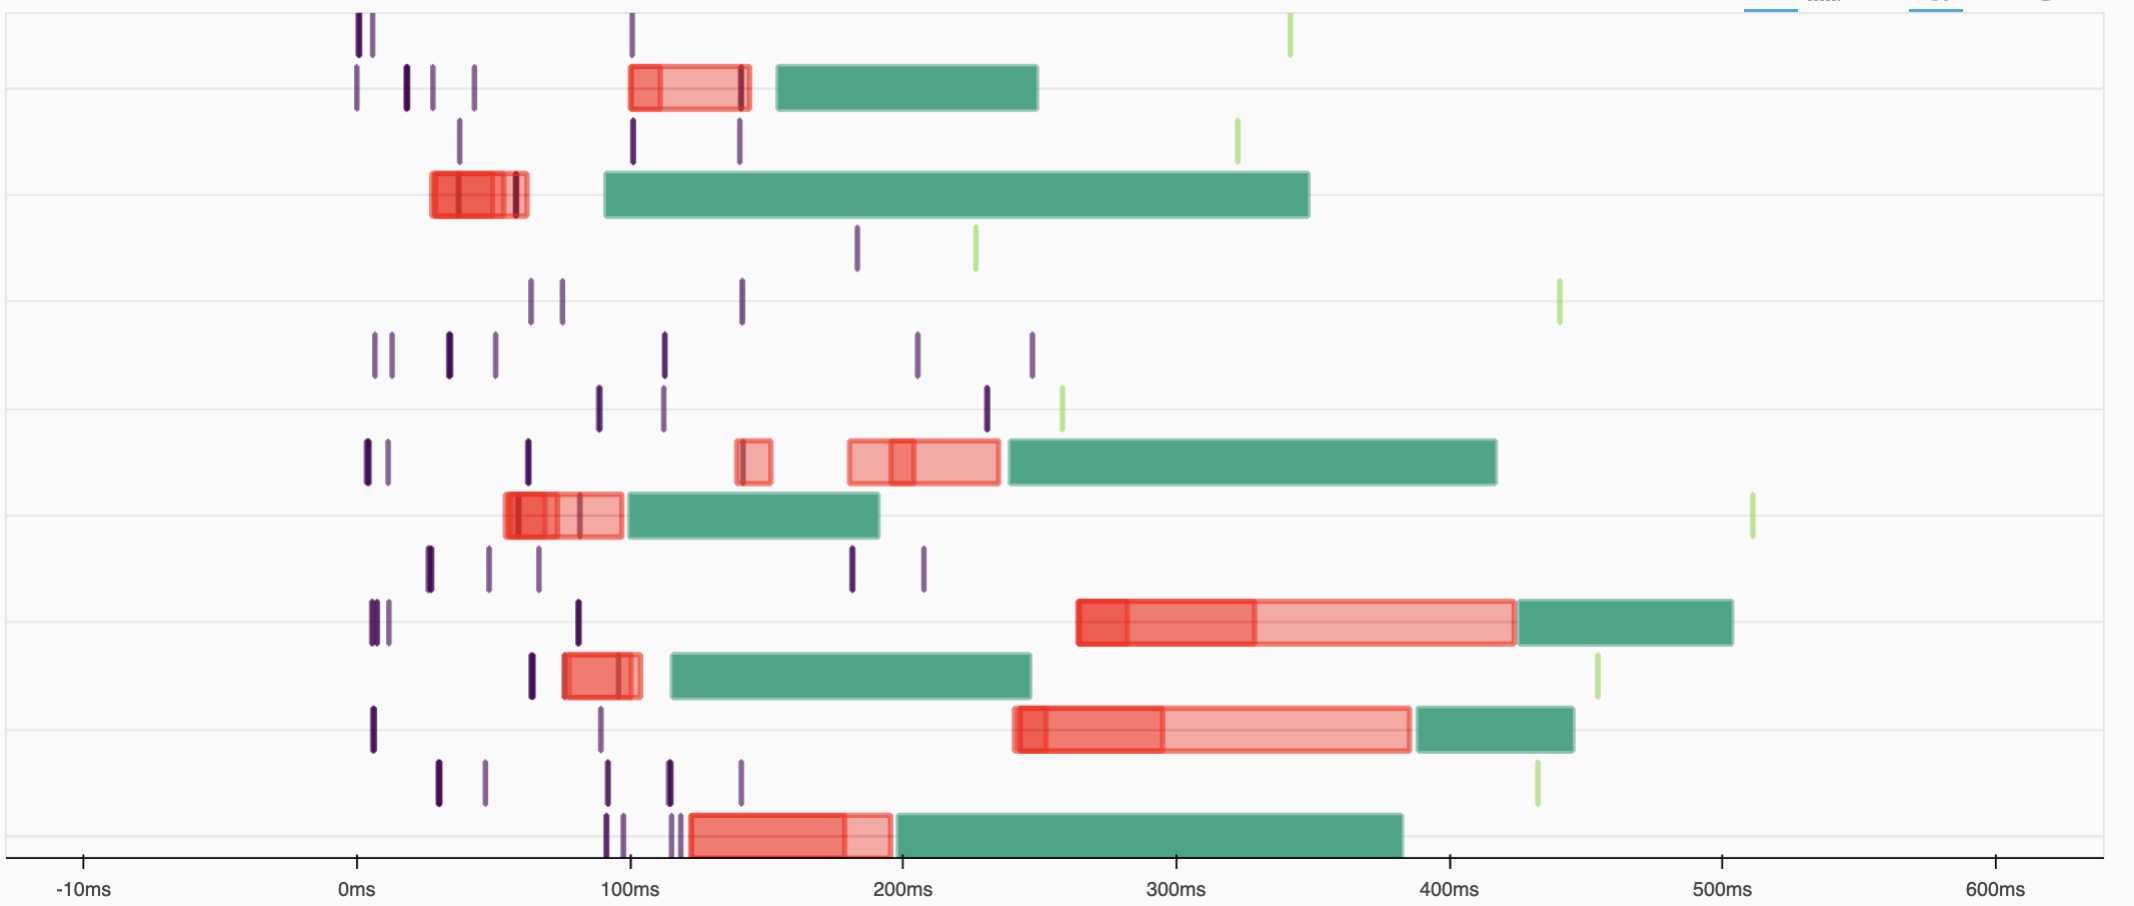

In [90]:
%%time

# Cosine similarity with the first 10 papers and the first 100 papers.
part4 =(db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in range(10) for j in range(100) ])
                .repartition(8).map(make_sim_bag).compute())


for worker_address in worker_addresses:
    worker_info = c.scheduler_info()["workers"][worker_address]
    cpu_usage = worker_info["metrics"]["cpu"]
    print(f"Worker {worker_address} CPU Usage: {cpu_usage}")


del part4

Worker tcp://10.67.22.100:38817 CPU Usage: 2.0
Worker tcp://10.67.22.100:45631 CPU Usage: 4.0
Worker tcp://10.67.22.209:43387 CPU Usage: 2.0
Worker tcp://10.67.22.209:46567 CPU Usage: 108.0
CPU times: user 29.8 s, sys: 147 ms, total: 30 s
Wall time: 34.5 s


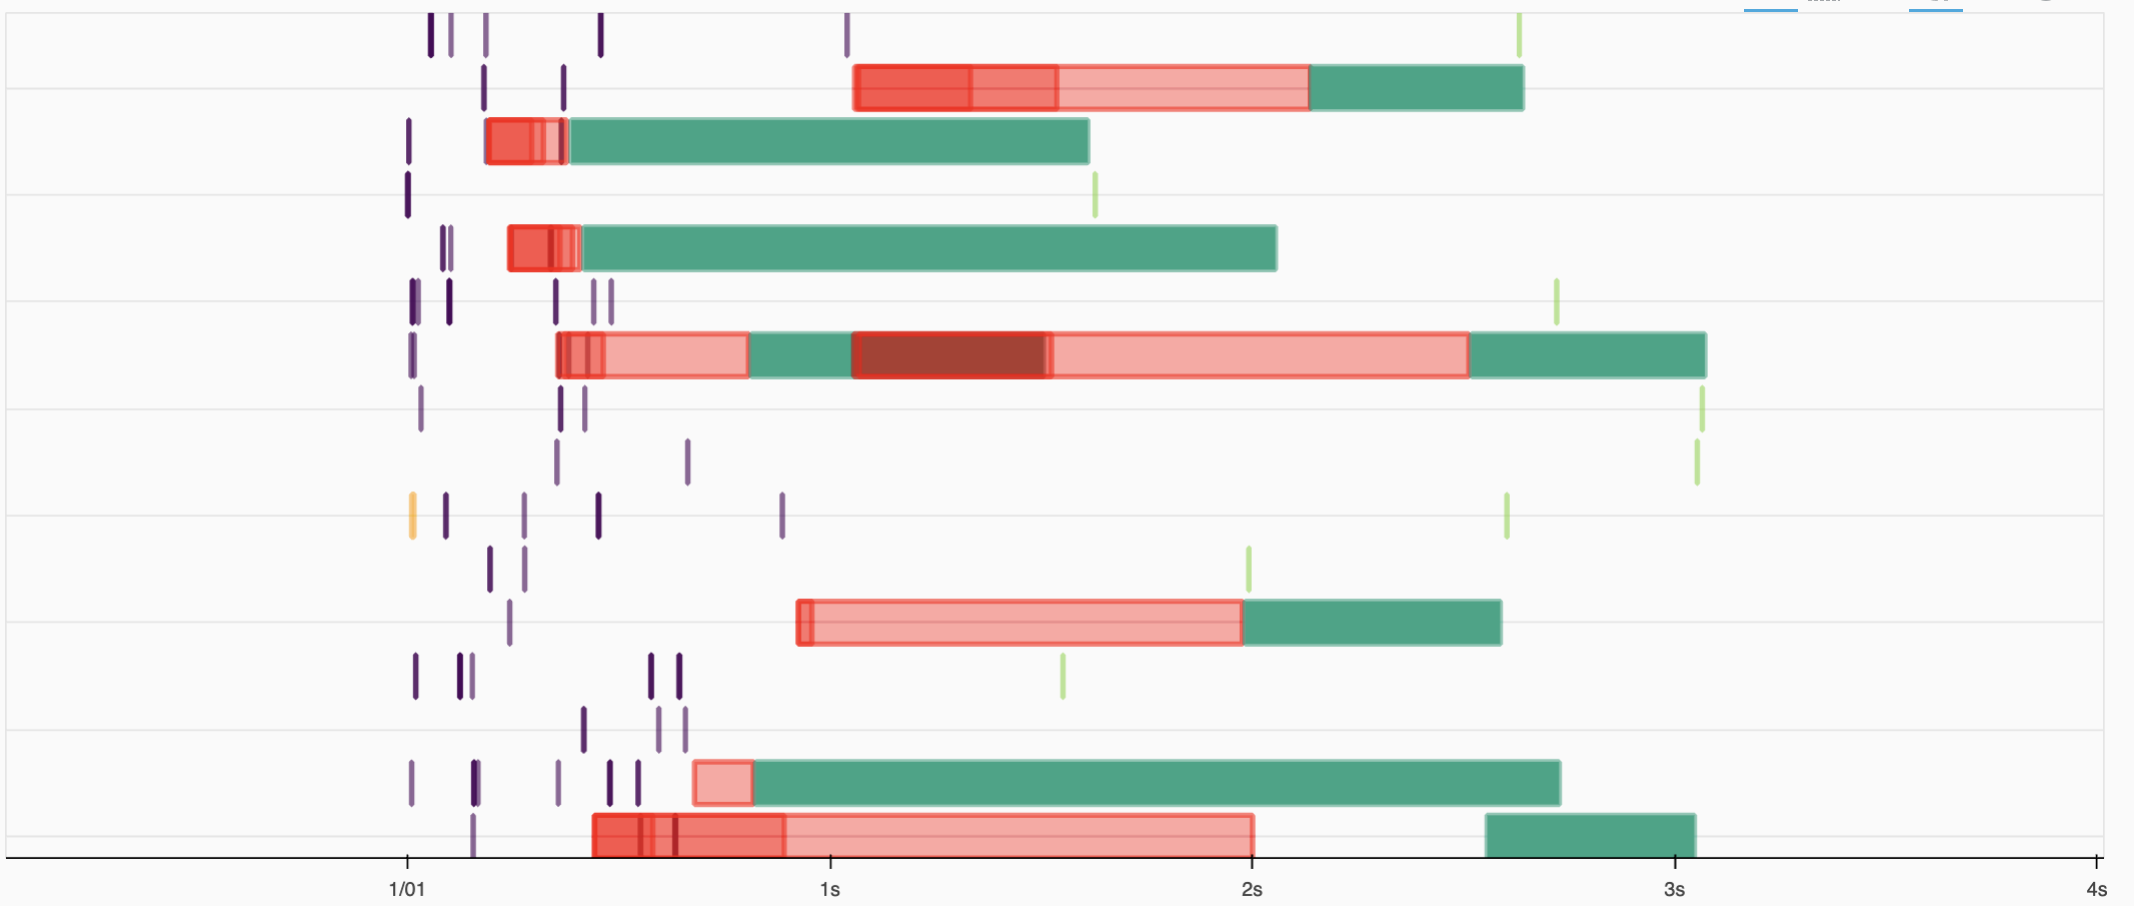

**DO NOT RUN THIS:**

In [ ]:
%%time
### do not run this ###### 
#################     freeze     ############################
# cosine similarity between paper 0 and first 500 papers.



part4 =(db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in [0] for j in range(500) ])
                .repartition(8).map(make_sim_bag).compute())

for worker_address in worker_addresses:
    worker_info = c.scheduler_info()["workers"][worker_address]
    cpu_usage = worker_info["metrics"]["cpu"]
    print(f"Worker {worker_address} CPU Usage: {cpu_usage}")

del part4

In [29]:
# a Hacky and lazy way of using the chunk sizes, we wanted to change the chunk sizes easily.

main = list(range(0, 900 + 1, 10))
main.append(914)

p1 = list(range(0, 100 , 10))
p1.append(99)
p2 = list(range(100, 200 , 10))
p2.append(199)
p3 = list(range(200, 300 , 10))
p3.append(299)
p4 = list(range(300, 400 , 10))
p4.append(399)
p5 = list(range(400, 500 , 10))
p5.append(499)
p6 = list(range(500, 600 , 10))
p6.append(599)
p7 = list(range(600, 700 , 10))
p7.append(699)
p8 = list(range(700, 800 , 10))
p8.append(799)
p9 = list(range(800, 900 +1 ,10))
p9.append(914)



In [30]:



def large_computation(p):
    L = []
    
        
    
    
    part = (db.from_sequence([(titles_embedded[a], titles_embedded[b]) for a in range(p[0], p[1]) for b in range(p[0], p[1]) ])
                .repartition(8).map(make_sim_bag).compute())
    L+part
    del part
    for i in range(len(p) - 1):
        for j in range(i+1, len(main)-1):
            a = (db.from_sequence([(titles_embedded[n], titles_embedded[m]) for n in range(p[i], p[i+1]) for m in range(main[j], main[j+1]) ])
                .repartition(8).map(make_sim_bag).compute())


            L = L+a
            del a
    globals()["L_{}".format(p)] = L
    
    return globals()["L_{}".format(p)]
    


In [ ]:
large_computation(p1)

**the picture below is for batch sizes of 10X10.**

As depicted above, for a chunk size of 10, the process is performed smoothly without the overhead in the loop section of the code; however, it takes ages to run a comparison of alomost 1000 papers with themselves(1000 x 1000). the portion of the gaps with respcet to each calculation is large. 

One thing that we recommend is to apply parallel calculations inside these gaps.

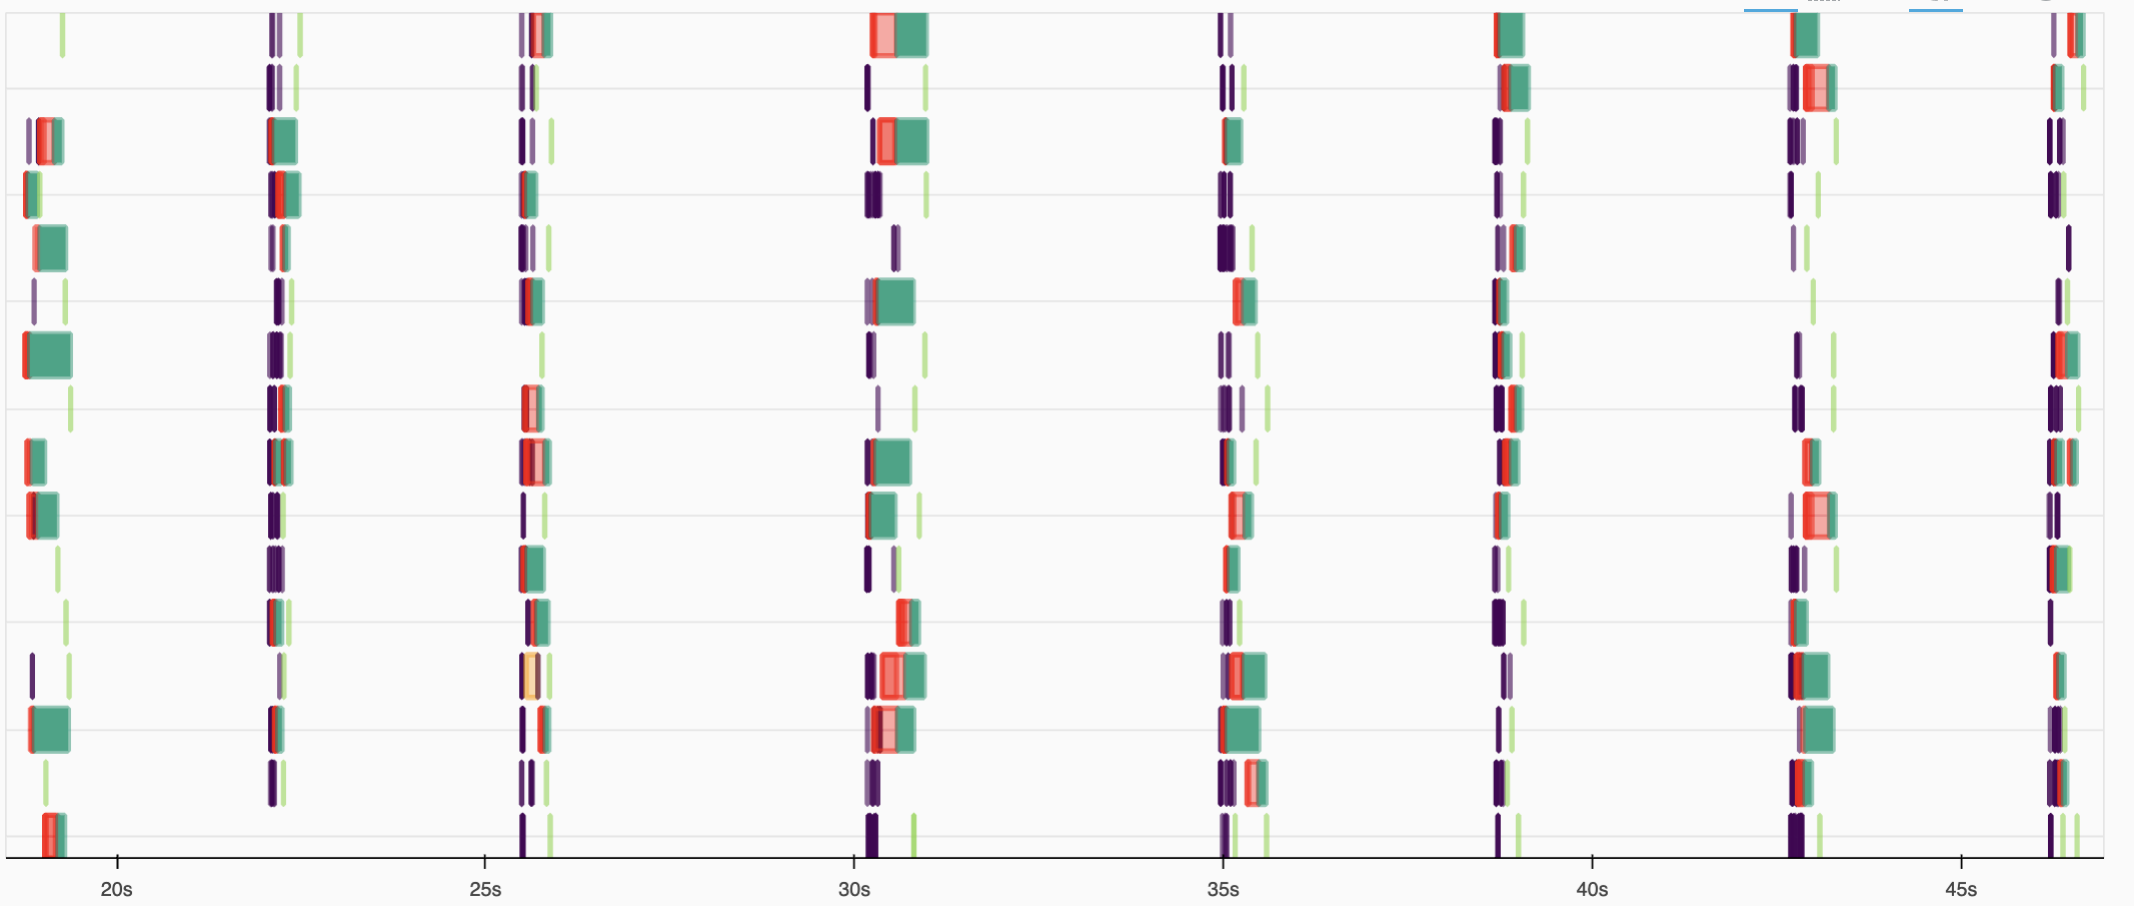

##### 3.2.1.1 which size is more suitable?

because we have used for loop in the formula, for the large chunk sizes we face a problem, since the `for loop` becomes very heavy, and since the loop is not distributed, it only runs on our scheduler which is the smallest machine we have. Consequently, for large chunk sizes, the cosine similarity calculation initializes very late due to the `for loop`. On the other hand, sizes like 1 X 10 is very small and it takes time to calculate the calculation of 1000 X 1000 papers.We have chosen 10 X 10 since the `for loop` was not problematic and the workers were working smoothly but the problem with this size is it takes time. As a result, we were not successfull to fully calculate the cosine similarity using the first method for all papers even by chuncking, and we think choosing cloudveneto.mediam for our scheduler was a big mistake, since if we had more cores we could have handled large chunk sizes better.

#### 3.2.2 second method:

In [35]:
def cosine_similarity(vec1, vec2):

    norm_vec1 = np.linalg.norm(vec1)   
    norm_vec2 =  np.linalg.norm(vec2)
    
    m = min(len(vec1), len(vec2)) # min of the length of either of two vectors is taken to compute inner product
    result = np.vdot(vec1[:m], vec2[:m])/(norm_vec1*norm_vec2)
    return result

In [36]:
def similarity(vec1, vec2):
    
    val = cosine_similarity(vec1['title'], vec2['title'])
    
    return{
        'paper 1': vec1['paper_id'],
        'paper 2' : vec2['paper_id'],
        'similarity' : val}

In [53]:
# Constructing a similarity matrix for method 2
dim = 20 # dimension of the matrix
sim_matrix_2 = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        vec_i = titles_embedded[i]
        vec_j = titles_embedded[j]
        sim_matrix_2[i][j] = similarity(vec_i,vec_j)['similarity']

In [54]:
#similarity of paper index 0 with the first 20 papers.
sim_matrix_2[0]

array([0.99999994, 0.22531961, 0.2598345 , 0.26225889, 0.28912675,
       0.27827477, 0.14164121, 0.3332355 , 0.28208902, 0.13651392,
       0.27103931, 0.27063981, 0.22073837, 0.2374312 , 0.26671177,
       0.07298476, 0.25851882, 0.35729271, 0.13791963, 0.11845709])

**The similarity contact matrix for first 20 papers with method 2:**

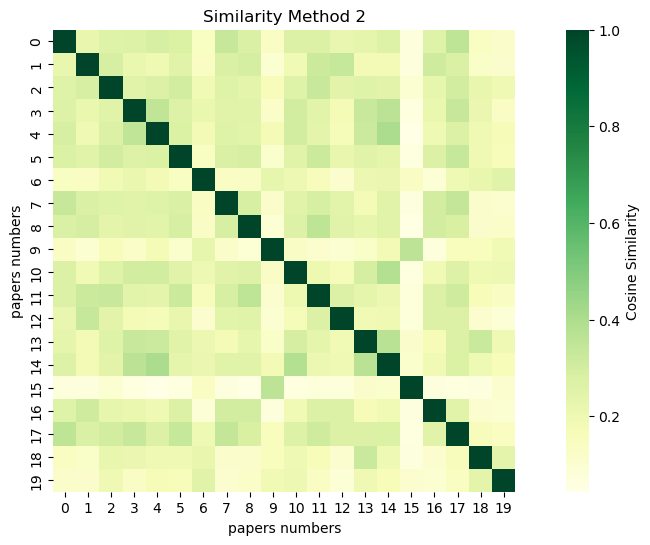

In [55]:
plt.figure(figsize=(13,6))

sns.heatmap(sim_matrix_2, cmap="YlGn",square=True, cbar_kws={'label':'Cosine Similarity'})
plt.xlabel('papers numbers')
plt.ylabel('papers numbers')
plt.title('Similarity Method 2')

plt.show()

In [26]:
chunk      = (db.from_sequence([(titles_embedded[i], titles_embedded[j]) for i in range(20) for j in range(20) ])
                .repartition(8).map(make_sim_bag).compute())

In [30]:
chunk[21]

{'Paper1:': '007a55caac4c46e49fa6f8b09a944b8610f78a81',
 'Paper2:': '007a55caac4c46e49fa6f8b09a944b8610f78a81',
 'Similarity': 1.0}

In [50]:
#creating a 20X20 matrix for method 1:

list_ = []
for i in range(len(chunk)):
    
    list_.append(chunk[i]['Similarity'])
    
sim_matrix_1 = np.array(list_).reshape(20, 20)

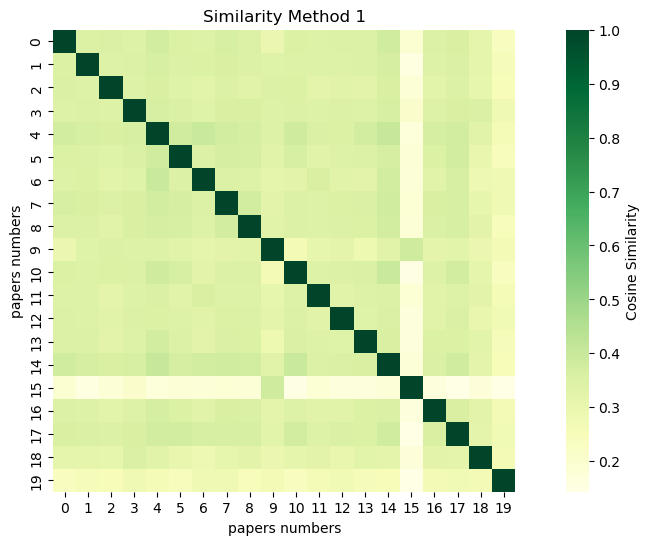

In [52]:
plt.figure(figsize=(13,6))

sns.heatmap(sim_matrix_1, cmap="YlGn",square=True, cbar_kws={'label':'Cosine Similarity'})
plt.xlabel('papers numbers')
plt.ylabel('papers numbers')
plt.title('Similarity Method 1')

plt.show()

#### 3.2.3 the method comparison between the first 20 papers:

we can see similar `white` patterns in both methods. However,paper 0 and 9 are more similar in method 1 than in method 2. As a good comparison we take these titles out to see which method is wrong.

In [64]:
data[0]

{'paper_id': '0032acf4de2905b7ce9d1b0835e5258a0cbbabf4',
 'title': 'The CEEDER database of evidence reviews: An open-access evidence service for researchers and decision-makers'}

In [63]:
data[9]

{'paper_id': '02b1f0fb34f67893e1651e08ea4f45c348132bd2',
 'title': 'Der Nervenarzt Wohnungslosigkeit und seelische Erkrankungen Hintergrund'}

**As we can see paper 9 title is in German !!!! so the white pattern for paper 9 with other papers in method 2 make sense, and it shows method 2 is more accurate here; however, we think if we could manage to omit median among similarities of words between two titles, method 1 would have become more accurate.**

#### 3.2.4 performance analysis for method 1 for different number of workers and partitions:

In [25]:
main = list(range(0, 200, 10))
p1 = list(range(0, 20 , 10))

In [22]:
n_workers = [1, 2, 3]
n_partitions=[5, 10, 50, 100, 500]
file_path = '/home/ubuntu/data/Melika.py'



def Clusterf(path):
    warnings.filterwarnings("ignore")
    client = Client()
    for w in n_workers:
        client.close()
        client = None
        cluster = SSHCluster(
            ["localhost",w1, w2],connect_options={"known_hosts": None, "username": "ubuntu", "client_keys": ["~/.ssh/daskM"]}
            ,worker_options={"nthreads": 2, "n_workers": w},
            scheduler_options={"port": 0, "dashboard_address": ":8797"})
        client = Client(cluster)



        globals()['TW_{}'.format(w)] = []
        Ns = n_partitions
        for n in Ns:
            start_time = time.time()
            exec(open(path).read())
            end_time = time.time()
            globals()['Time_{}'.format(n)] = end_time - start_time
            globals()['TW_{}'.format(w)].append(globals()['Time_{}'.format(n)])
            print(f"Execution time: {globals()['Time_{}'.format(n)]:.2f} seconds")

In [23]:
Clusterf(file_path)

2023-07-09 17:08:27,215 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8797 is already in use.
2023-07-09 17:08:27,219 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-09 17:08:27,221 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 41845 instead
2023-07-09 17:08:27,223 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-09 17:08:27,224 - distributed.deploy.ssh - INFO - 2023-07-09 17:08:27,214 - distributed.scheduler - INFO - State start
2023-07-09 17:08:27,228 - distributed.deploy.ssh - INFO - 2023-07-09 17:08:27,218 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:44409
2023-07-09 17:08:28,924 - distributed.deploy.ssh - INFO - 2023-07-09 17:08:28,923 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:33321'
2023-07-09 17:08:28,981 - distributed.deploy.ssh - INFO - 2023-07-09 17:08:28,975 - distributed.na

Execution time: 80.73 seconds
Execution time: 79.49 seconds
Execution time: 79.86 seconds
Execution time: 78.59 seconds
Execution time: 80.23 seconds


2023-07-09 17:15:10,413 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8797 is already in use.
2023-07-09 17:15:10,414 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-09 17:15:10,416 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 41161 instead
2023-07-09 17:15:10,417 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-09 17:15:10,418 - distributed.deploy.ssh - INFO - 2023-07-09 17:15:10,412 - distributed.scheduler - INFO - State start
2023-07-09 17:15:10,424 - distributed.deploy.ssh - INFO - 2023-07-09 17:15:10,423 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:44239
2023-07-09 17:15:12,226 - distributed.deploy.ssh - INFO - 2023-07-09 17:15:12,220 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:42201'
2023-07-09 17:15:12,236 - distributed.deploy.ssh - INFO - 2023-07-09 17:15:12,230 - distributed.na

Execution time: 72.69 seconds
Execution time: 72.50 seconds
Execution time: 73.92 seconds
Execution time: 73.46 seconds
Execution time: 75.20 seconds


2023-07-09 17:21:22,764 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8797 is already in use.
2023-07-09 17:21:22,766 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-09 17:21:22,767 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 35747 instead
2023-07-09 17:21:22,768 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-09 17:21:22,768 - distributed.deploy.ssh - INFO - 2023-07-09 17:21:22,763 - distributed.scheduler - INFO - State start
2023-07-09 17:21:22,769 - distributed.deploy.ssh - INFO - 2023-07-09 17:21:22,765 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:34867
2023-07-09 17:21:24,576 - distributed.deploy.ssh - INFO - 2023-07-09 17:21:24,569 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:42045'
2023-07-09 17:21:24,584 - distributed.deploy.ssh - INFO - 2023-07-09 17:21:24,584 - distributed.na

Execution time: 71.16 seconds
Execution time: 73.38 seconds
Execution time: 70.37 seconds
Execution time: 69.99 seconds
Execution time: 70.09 seconds


In [24]:
df_3 = pd.DataFrame(
    {"w = 1": TW_1,
     "w = 2": TW_2,
     "w = 3": TW_3}, index = n_partitions)


df_3.to_csv('/home/ubuntu/data/Melika_1.csv')

In [26]:
n_workers = [4, 5]
n_partitions=[5, 10, 50, 100, 500]
file_path = '/home/ubuntu/data/Melika.py'



def Clusterf(path):
    warnings.filterwarnings("ignore")
    client = Client()
    for w in n_workers:
        client.close()
        client = None
        cluster = SSHCluster(
            ["localhost",w1, w2],connect_options={"known_hosts": None, "username": "ubuntu", "client_keys": ["~/.ssh/daskM"]}
            ,worker_options={"nthreads": 2, "n_workers": w},
            scheduler_options={"port": 0, "dashboard_address": ":8797"})
        client = Client(cluster)



        globals()['TW_{}'.format(w)] = []
        Ns = n_partitions
        for n in Ns:
            start_time = time.time()
            exec(open(path).read())
            end_time = time.time()
            globals()['Time_{}'.format(n)] = end_time - start_time
            globals()['TW_{}'.format(w)].append(globals()['Time_{}'.format(n)])
            print(f"Execution time: {globals()['Time_{}'.format(n)]:.2f} seconds")

In [27]:
Clusterf(file_path)

2023-07-09 18:09:08,585 - distributed.deploy.ssh - INFO - 2023-07-09 18:09:08,584 - distributed.scheduler - INFO - State start
2023-07-09 18:09:08,588 - distributed.deploy.ssh - INFO - 2023-07-09 18:09:08,587 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:37855
2023-07-09 18:09:10,194 - distributed.deploy.ssh - INFO - 2023-07-09 18:09:10,187 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:46425'
2023-07-09 18:09:10,207 - distributed.deploy.ssh - INFO - 2023-07-09 18:09:10,201 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:45649'
2023-07-09 18:09:10,211 - distributed.deploy.ssh - INFO - 2023-07-09 18:09:10,205 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:34945'
2023-07-09 18:09:10,225 - distributed.deploy.ssh - INFO - 2023-07-09 18:09:10,219 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:41533'
2023-07-09 18:09:10,228 - distributed.deploy.ssh - INFO - 2023-07-09

Execution time: 66.50 seconds
Execution time: 67.80 seconds
Execution time: 67.04 seconds
Execution time: 68.02 seconds
Execution time: 66.86 seconds


2023-07-09 18:14:48,924 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda3/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8797 is already in use.
2023-07-09 18:14:48,926 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-09 18:14:48,927 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 35975 instead
2023-07-09 18:14:48,929 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-09 18:14:48,931 - distributed.deploy.ssh - INFO - 2023-07-09 18:14:48,923 - distributed.scheduler - INFO - State start
2023-07-09 18:14:48,933 - distributed.deploy.ssh - INFO - 2023-07-09 18:14:48,927 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.24:39069
2023-07-09 18:14:50,648 - distributed.deploy.ssh - INFO - 2023-07-09 18:14:50,641 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.209:33221'
2023-07-09 18:14:50,665 - distributed.deploy.ssh - INFO - 2023-07-09 18:14:50,657 - distributed.na

Execution time: 67.64 seconds
Execution time: 69.72 seconds
Execution time: 68.80 seconds
Execution time: 67.82 seconds
Execution time: 67.53 seconds


In [ ]:
df_4 = pd.DataFrame(
    {"w = 4": TW_4,
     "w = 5": TW_5
    }, index = n_partitions)


df_4.to_csv('/home/ubuntu/data/Melika_2.csv')

In [21]:
df_3 = pd.read_csv('/home/ubuntu/data/Melika_1.csv')
df_4 = pd.read_csv('/home/ubuntu/data/Melika_2.csv')


In [22]:

df_4.columns = df_4.columns.str.replace('Unnamed: 0', 'Partitions')
df_4.set_index('Partitions', inplace = True)
df_4

,w = 4,w = 5
Partitions,,
5,66.496415,67.641601
10,67.800582,69.715400
50,67.036788,68.800576
100,68.024111,67.820416
500,66.859549,67.533795


In [23]:
df_3.columns = df_3.columns.str.replace('Unnamed: 0', 'Partitions')
df_3.set_index('Partitions', inplace = True)
df_3

,w = 1,w = 2,w = 3
Partitions,,,
5,80.729280,72.694037,71.159936
10,79.489160,72.503531,73.377143
50,79.857969,73.916380,70.373770
100,78.587945,73.456443,69.987801
500,80.230707,75.202213,70.090952


In [24]:
df_ = pd.merge(df_3, df_4, left_index=True, right_index=True)
df_

,w = 1,w = 2,w = 3,w = 4,w = 5
Partitions,,,,,
5,80.729280,72.694037,71.159936,66.496415,67.641601
10,79.489160,72.503531,73.377143,67.800582,69.715400
50,79.857969,73.916380,70.373770,67.036788,68.800576
100,78.587945,73.456443,69.987801,68.024111,67.820416
500,80.230707,75.202213,70.090952,66.859549,67.533795


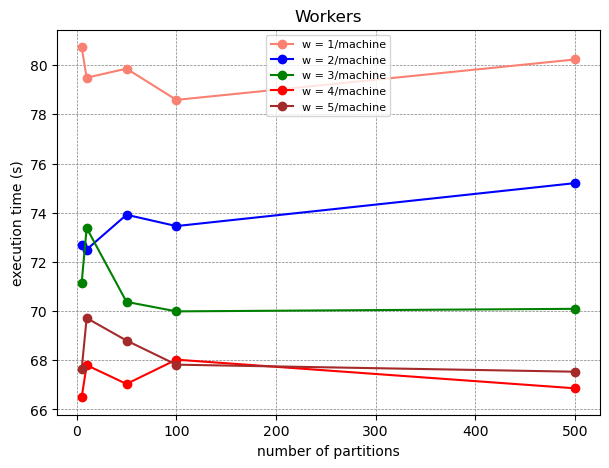

In [26]:
plt.figure(figsize=(7,5))

plt.plot(df_.index, df_['w = 1'], marker = 'o', c = 'salmon', label = 'w = 1/machine')
plt.plot(df_.index, df_['w = 2'], marker = 'o', c = 'blue', label = 'w = 2/machine')
plt.plot(df_.index, df_['w = 3'], marker = 'o', c = 'green', label = 'w = 3/machine')
plt.plot(df_.index, df_['w = 4'], marker = 'o', c = 'red', label = 'w = 4/machine')
plt.plot(df_.index, df_['w = 5'], marker = 'o', c = 'brown', label = 'w = 5/machine')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.xlabel('number of partitions')
plt.ylabel('execution time (s)')
plt.title('Workers')
plt.legend(loc = 'best', fontsize = 8)
plt.show()

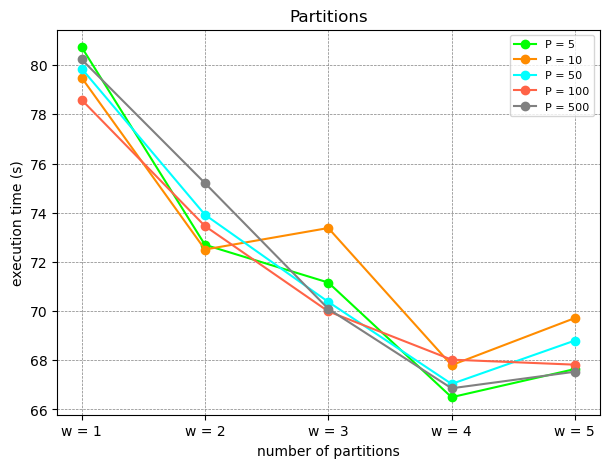

In [27]:
plt.figure(figsize=(7,5))

plt.plot(df_.columns, df_.iloc[0, :], marker = 'o', c = 'lime', label = 'P = 5')
plt.plot(df_.columns, df_.iloc[1, :], marker = 'o', c = 'darkorange', label = 'P = 10')
plt.plot(df_.columns, df_.iloc[2, :], marker = 'o', c = 'aqua', label = 'P = 50')
plt.plot(df_.columns, df_.iloc[3, :], marker = 'o', c = 'tomato', label = 'P = 100')
plt.plot(df_.columns, df_.iloc[4, :], marker = 'o', c = 'gray', label = 'P = 500')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.xlabel('number of partitions')
plt.ylabel('execution time (s)')
plt.title('Partitions')
plt.legend(loc = 'upper right', fontsize = 8)
plt.show()

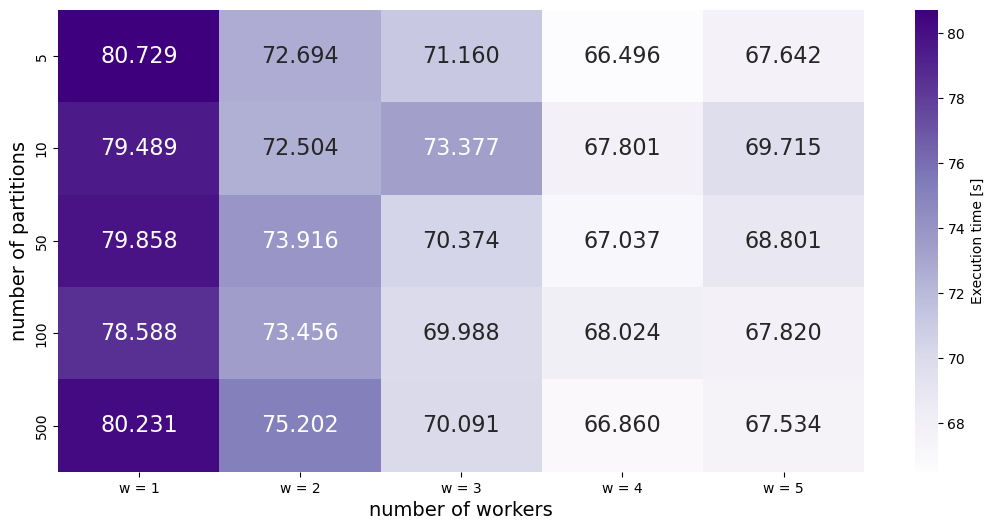

In [30]:
plt.figure(figsize=(13,6))
sn.heatmap(df_, annot=True, annot_kws={"size": 16},fmt=".3f",
               cbar_kws={'label':'Execution time [s]'},cmap="Purples")

plt.xlabel('number of workers',fontsize=14)
plt.ylabel('number of partitions',fontsize=14)
plt.show()
plt.style.use('default')

## 4. Suggestions for later study:

1. Better machine for scheduler.
2. Substitute the for loop in method 1 for similarity for calculating the chunks because it is very problematic or just find a way to do another task in the gap which is made by the for loop.
3. Maybe omit the median between similarities of words between two titles, and substitute it with something that make sense.